# ※ 프로젝트 목표
- 부동산 뉴스 데이터와 아파트매매가격지수와의 연관성 및 상관관계 분석
- 부동산 뉴스 데이터를 활용하여 2021년 아파트 가격을 예측해보기<br>
  (비정형 데이터를 TF Vectorizing으로 수치화시켜 1달전 뉴스데이터를 입력변수로 아파트매매가격지수를 종속변수로 학습 모델링
- 감성지수, 주요 뉴스 및 키워드 추출

필요한 라이브러리 호출

In [2]:
import os
import pandas as pd
import numpy as np
import requests
import re, os, math
import collections
import pickle
from datetime import datetime
import time
import json

from bs4 import BeautifulSoup
from dateutil.relativedelta import relativedelta

from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import sys
sys.path.insert(0, "Users\medici\Desktop\clustering4docs-master\soyclustering")
from soyclustering import SphericalKMeans

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize']= 12,6
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import *

In [4]:
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 수집(크롤링)
- 부동산 : 아파트 실거래가 상세조회 오픈 api, KB 주간 아파트매매가격지수
- 뉴스 : 빅카인즈 오픈API, 빅카인즈 뉴스검색및다운로드

## 1) 공공데이터 오픈API(아파트실거래 상세조회)

### - 기본값 설정

In [2]:
api_limit = 10000  #max : 1000000
baseurl = 'http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev'
servicekey = 'Ex36SLserq7pqUqFo2O9VRpkce6bHGi2zwKRgdo%2BBLxi77pw2lgEqLR67DQkh3x5q%2Bhn5hLN8BKk6dJgPFjTWw%3D%3D'
dealym = '202101'
headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36'}

parsed_data = []

### - 함수 생성

[get_dealym] 시작일부터 종료일까지의 날짜

In [3]:
def get_dealym(start_ym, end_ym) :
    res = []
    start = datetime.strptime(start_ym, '%Y%m')
    end = datetime.strptime(end_ym, '%Y%m')
    diff = (end.year - start.year) * 12 + (end.month  - start.month) + 1
    for i in range(diff) :
        res.append(datetime.strftime(start + relativedelta(months = i), '%Y%m')) # 기준날짜에 대한 연산이 필요할때 relativedelta
    return res

[get_url] url 가져오기

In [4]:
def get_url(pageno, lawd_cd, deal_ym) :
    params = {'ServiceKey' : servicekey, 
              'pageNo' : pageno, 
              'numOfRows' : '10', 
              'LAWD_CD' : lawd_cd, 
              'DEAL_YMD' : deal_ym }

    url = baseurl + '?' + '&'.join(['{}={}'.format(k,v) for k, v in params.items()])
    return url

[get_data] request로 xml에서 필요한 데이터 가져오기

In [5]:
def get_data(url) :
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, 'lxml-xml')
    items = soup.findAll('item')
    return items

[get_data_firstpg] 전체 결과에 대한 page수 확인

In [6]:
def get_data_firstpg(url) :
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml-xml')
    items = soup.findAll('item')
    totalcount = int(soup.find('totalCount').text)
    return items, 1 + int(totalcount/10)

[parse_text] if문으로 null값 호출시 error해결

In [7]:
def parse_text(soup_object) : 
    if soup_object :
        return soup_object.text
    else :
        return ''

[parse_item] 데이터 파싱

In [8]:
def parse_item(item, deal_ym) :
    amount = parse_text(item.find('거래금액')).strip().replace(',', '')
    
    road_aptcode = parse_text(item.find('도로명건물본번호코드'))
    road_aptcode2 = parse_text(item.find('도로명건물부번호코드'))
    road_addr = item.find('도로명')
    if item.find('도로명') == '' :
        road_addr = ''
    else :
        road_addr = parse_text(item.find('도로명')).strip()

    if road_addr == '' :
        road_addr = ''
    elif (road_aptcode2 == '00000') or (road_aptcode2 == ''):
        road_addr = "{} {}".format(road_addr, int(road_aptcode))
    else :
        road_addr = "{} {}-{}".format(road_addr, int(road_aptcode), int(road_aptcode2))

    apt_dong = parse_text(item.find('법정동'))
    apt_lawd = parse_text(item.find('법정동시군구코드'))    
    apt_name = parse_text(item.find('아파트'))
    apt_year = parse_text(item.find('건축년도'))
    apt_area = parse_text(item.find('전용면적'))
    apt_floor = parse_text(item.find('층'))
    deal_y = int(str(deal_ym)[:4])
    deal_m = parse_text(item.find('월'))
    deal_d = parse_text(item.find('일'))
    deal_ymd = "{}{:02d}{:02d}".format(deal_y, int(deal_m), int(deal_d))
    deal_datetime = datetime.strptime(deal_ymd, '%Y%m%d')
    
    res = {'아파트' : apt_name, '건축년도' : int(apt_year), '전용면적' : float(apt_area), '층' : int(apt_floor),
           '거래금액' : int(amount), '주소' : road_addr, '법정동' : apt_dong, '법정동코드' : apt_lawd, 
           '거래일자' : deal_datetime, '거래일_연도' : deal_y, '거래일_월' : deal_m, '거래일_일' : deal_d,
          }
    return res

[run] 실행함수

In [9]:
def run(pageno, lawd_cd, deal_ym) :
    url = get_url(pageno, lawd_cd, deal_ym)
    print(url)
    items = get_data(url)
    if items :
        parsed_data.extend([parse_item(x, deal_ym) for x in items])
        return True
    else :
        return False

[save_data] 데이터 저장

In [10]:
def save_data(parsed_data) :
    df = pd.DataFrame(parsed_data)
    df.to_csv("C:/Users/medici/Desktop/국비교육/기업연계프로젝트/1. 데이터 수집\데이터 수집/크롤링 및 open API/부동산/data/apt_deal_2021_01_08.csv" ,index=True, encoding='utf-8-sig')

### - [main] 수집

In [ ]:
%%time

if __name__ == '__main__' : #필수적인 것(그냥외워두삼)
    start_ym = '202101'
    end_ym = '202108'

    ls_dealym = get_dealym(start_ym, end_ym) #날짜리스트
    lawd_csv_path = 'data/apt_dongcode.csv' #법정동코드 파일 위치
    df_lawd = pd.read_csv(lawd_csv_path, encoding='utf-8-sig')
    ls_lawd = list(df_lawd['법정동코드']) #법정동리스트
    dealym = ls_dealym[0]

    pg = 1
    lawd = ls_lawd[0]

    if dealym != ls_dealym[0] :
        idx_ym = ls_dealym.index(dealym)

        ls_dealym = ls_dealym[idx_ym:]

    if lawd != ls_lawd[0] :
        idx_lawd = ls_lawd.index(lawd)
        ls_lawd = ls_lawd[idx_lawd:]

    count = 0.1

    for lawdcode in ls_lawd :
        for ym in ls_dealym :
            while(run(pg, lawdcode, ym)) :
                count += 1
                pg += 1
                time.sleep(0.1)
                if count >= api_limit :
                    pg_next = pg+1
                    break
            
            if count >= api_limit :
                pg_next = pg
                break

            count += 1
            pg = 1

        else :
            continue
        break

    '''for lawdcode in ls_lawd :
        for ym in ls_dealym :
            url_firstpg = get_url(1, lawdcode, ym)
            items, pg_end = get_data_firstpg(url_firstpg)
            print(url_firstpg)
            count += 1
            if items :
                parsed_data.extend([parse_item(x, ym) for x in items])
            if pg_end > 1 :
                for pg in range(2, pg_end+1) :
                    run(pg, lawdcode, ym)
                    count += 1
                    time.sleep(1)
                    if count >= api_limit :
                        pg_next = pg+1 if pg != pg_end else 1
                        break
            
            if count >= api_limit :
                pg_next = 1
                break
            
        else :
            continue
        break'''


    save_data(parsed_data) #데이터저장
    #마지막저장기록 
    now = datetime.strftime(datetime.now(), '%Y-%m-%d %H:%M')
    with open('C:/Users/medici/Desktop/국비교육/기업연계프로젝트/1. 데이터 수집\데이터 수집/크롤링 및 open API/부동산/openapi_log.txt', 'a+') as f :
        f.write("크롤링날짜\t법정동코드\t거래일\t페이지\n")
        f.write("{}\t{}\t{}\t".format(now, lawdcode, ym))
        f.close()

http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev?ServiceKey=Ex36SLserq7pqUqFo2O9VRpkce6bHGi2zwKRgdo%2BBLxi77pw2lgEqLR67DQkh3x5q%2Bhn5hLN8BKk6dJgPFjTWw%3D%3D&pageNo=1&numOfRows=10&LAWD_CD=11110&DEAL_YMD=202101
http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev?ServiceKey=Ex36SLserq7pqUqFo2O9VRpkce6bHGi2zwKRgdo%2BBLxi77pw2lgEqLR67DQkh3x5q%2Bhn5hLN8BKk6dJgPFjTWw%3D%3D&pageNo=2&numOfRows=10&LAWD_CD=11110&DEAL_YMD=202101
http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev?ServiceKey=Ex36SLserq7pqUqFo2O9VRpkce6bHGi2zwKRgdo%2BBLxi77pw2lgEqLR67DQkh3x5q%2Bhn5hLN8BKk6dJgPFjTWw%3D%3D&pageNo=3&numOfRows=10&LAWD_CD=11110&DEAL_YMD=202101
http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev?ServiceKey=Ex36SLserq7pqUqFo2O9VRpkce6bHGi2zwKRgdo%2BBLxi77pw2lgEqLR67DQkh3x5q%2Bhn5hLN8BKk6dJgPFjTWw%3D

## 2) 빅카인즈 뉴스 오픈API

### - 기본값 설정

In [2]:
url = 'http://tools.kinds.or.kr:8888/search/news'
query = '부동산 AND 아파트'
start_ymd = '2020-01-01'   #1일 단위로 설정
end_ymd = '2021-09-01'     #1일 단위로 설정
#return_from = 0
#return_size = 100000 # 1만개까지 
parsed_data = []

### - 함수 생성

[get_ymd] 시작일부터 종료일까지의 날짜

In [3]:
def get_ymd(start_ymd, end_ymd) :
    res = []
    start = datetime.strptime(start_ymd, '%Y-%m-%d')
    end = datetime.strptime(end_ymd, '%Y-%m-%d')
    diff = (end.year - start.year) * 12 + (end.month  - start.month)
    for i in range(int(diff/2)) :              
        res.append(datetime.strftime(start + relativedelta(months = 2*i), '%Y-%m-%d'))
    return res

[get_data] json형식으로 data 가져오기 

In [5]:
def get_data(url) :
    params = {
        "access_key": "cef63bff-8972-4140-82b6-2be184378ccc",
        "argument": {
            "query": query,
            "published_at": {
                "from": start_ymd,
                "until": end_ymd
            },
            "sort": {"date": "desc"},
            "hilight": 200,
            "return_from": 0,
            "return_size": 10000,
            "fields": [
                "byline",
                "category",
                "category_incident",
                "provider_news_id",
                "content",  
                "hilight",  
            ]
        }
    }

    headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36'}
    
    r = requests.post(url, json=params, headers=headers)
    results = r.json()
    return results['return_object']['documents']

[parse_result] 데이터 파싱

In [7]:
def parse_result(result) :
    news_id = result.get('news_id')
    title = result.get('title')
    content = result.get('content')
    hilight = result.get('hilight')
    news_published_at = result.get('published_at')
    provider = result.get('provider')
    category = result.get('category')
    category_incident = result.get('category_incident')
    if category_incident == "[]" :
        category_incident = ""
    else :
        category_incident

    
    res = {'언론사' : provider , '뉴스식별번호' : news_id, '뉴스출고시간' : news_published_at, 
           '카테고리' : category, '카테고리체계' : category_incident,
           '뉴스제목' : title, '뉴스본문' : content, '하이라이트' : hilight}
    
    return res

[run] 실행함수

In [6]:
def run(url) :
    results = get_data(url)
    if results :
        parsed_data.extend([parse_result(x) for x in list(results)])
        return True
    else :
        return False

[save_data] 데이터 저장

In [7]:
def save_data(parsed_data) :
    df = pd.DataFrame(parsed_data)
    df.to_csv("C:/Users/medici/Desktop/국비교육/기업연계프로젝트/1. 데이터 수집\데이터 수집/크롤링 및 open API/빅카인즈/data/bigkinds_news_202001_202109.csv" ,index=True, encoding='utf-8-sig')   # 날짜 수정
    return print(df.shape)

### - [main] 수집

In [8]:
%%time

if __name__ == '__main__' : # 메인실행을 위한 코드

    ymd_list = get_ymd(start_ymd, end_ymd) #날짜리스트

    for st in ymd_list :
        start_ymd = datetime.strptime(st, '%Y-%m-%d')
        end_ymd = datetime.strftime(start_ymd + relativedelta(months = 2), '%Y-%m-%d')
        start_ymd = str(start_ymd)[:10]
        print(start_ymd, end_ymd)       
        run(url)
        time.sleep(0.1)
       
    save_data(parsed_data) #데이터저장        
    #마지막저장기록 
    now = datetime.strftime(datetime.now(), '%Y-%m-%d %H:%M')

    with open('C:/Users/medici/Desktop/국비교육/기업연계프로젝트/1. 데이터 수집\데이터 수집/크롤링 및 open API/빅카인즈/data/openapi_log'+ start_ymd + end_ymd +'.txt', 'a+') as f :
        f.write("크롤링날짜\t시작일\t종료일\n")
        f.write("{}\t{}\t{}\n".format(now, start_ymd, end_ymd))
        f.close()


2020-01-01 2020-03-01
2020-03-01 2020-05-01
2020-05-01 2020-07-01
2020-07-01 2020-09-01
2020-09-01 2020-11-01
2020-11-01 2021-01-01
2021-01-01 2021-03-01
2021-03-01 2021-05-01
2021-05-01 2021-07-01
2021-07-01 2021-09-01
(66736, 8)
Wall time: 1min 24s


# 2. 데이터 전처리
  - 이상치 확인 및 결측치 제거
  - Regex로 불필요한 단어 제거
  - 토크나이징(빅카인즈에서 이미 토크나이징해서 keyword를 제공)
  - 형태소 분석기(OKT)
  - 불용어처리(stopwords)
  - filtering(경제>부동산, 단어길이 1, 빈도수 3회 이하, 특정뉴스기사, 영단어 제거
  - bow, tf-idf : 단어의 빈도를 벡터화시켜 나타냄

## 1) raw data 불러오기

In [6]:
BASE_DIR = 'C:/Users/medici/Desktop/국비교육/기업연계프로젝트/1. 데이터 수집/데이터 수집/크롤링 및 open API/'

In [7]:
BASE_DIR_APT = os.path.join(BASE_DIR, '부동산/data/df_apt_prep.csv')
BASE_DIR_NEWS =  os.path.join(BASE_DIR, '빅카인즈/data/NewsResult_2010to202108_FIN.csv')
print(BASE_DIR_APT)
print(BASE_DIR_NEWS)

C:/Users/medici/Desktop/국비교육/기업연계프로젝트/1. 데이터 수집/데이터 수집/크롤링 및 open API/부동산/data/df_apt_prep.csv
C:/Users/medici/Desktop/국비교육/기업연계프로젝트/1. 데이터 수집/데이터 수집/크롤링 및 open API/빅카인즈/data/NewsResult_2010to202108_FIN.csv


In [8]:
df_APT_raw = pd.read_csv(BASE_DIR_APT, encoding='utf-8-sig',  low_memory=False)
df_NEWS_raw = pd.read_csv(BASE_DIR_NEWS, encoding='utf-8-sig',  low_memory=False)

In [9]:
df_test = pd.read_excel('data/test_data_2106_2109.xlsx')

### - column명 변경

In [10]:
news_col = ['idx', 'news_id', 'published_at', 'provider', 'byline', 'title', 'category_1', 'category_2', 'category_3',
           'category_incident_1', 'category_incident_2', 'category_incident_3', 'PS', 'LC', 'OG', 'keyword',
           'feature_top50', 'content', 'url', 'except']
news_col2 = ['news_id', 'published_at', 'provider', 'byline', 'title', 'category_1', 'category_2', 'category_3',
           'category_incident_1', 'category_incident_2', 'category_incident_3', 'PS', 'LC', 'OG', 'keyword',
           'feature_top50', 'content', 'url', 'except']

In [11]:
df_NEWS = df_NEWS_raw.copy()

In [12]:
df_NEWS.columns = news_col
df_test.columns = news_col2

In [13]:
df_NEWS_merge = pd.concat([df_NEWS, df_test], axis=0) 

In [14]:
df_NEWS.drop(columns='idx', inplace=True)

In [15]:
print(len(df_NEWS))
print(len(df_test))
print(len(df_NEWS_merge))

298650
11369
310019


## 2) 결측치 처리

In [16]:
df_NEWS.isna().sum()

news_id                     0
published_at                0
provider                    0
byline                  51274
title                       0
category_1                  0
category_2              55529
category_3             113543
category_incident_1    265365
category_incident_2    294826
category_incident_3    297734
PS                     164251
LC                       8114
OG                       3559
keyword                     0
feature_top50               2
content                     0
url                     60384
except                 273023
dtype: int64

In [17]:
df_NEWS.dropna(subset=['feature_top50'], inplace = True)

In [18]:
df_NEWS['feature_top50'].isna().sum()

0

## 3) 파생변수 만들기 (feture_top10)

In [19]:
df_NEWS = df_NEWS_merge.sort_values('published_at')

In [20]:
#str -> list
#상위 10개 feature만 뽑아 새로운 col로 저장
df_NEWS['feature_top50'] = df_NEWS['feature_top50'].apply(lambda x : str(x).split(','))
df_NEWS['feature_top10'] = df_NEWS['feature_top50'].copy()
df_NEWS['feature_top10'] = df_NEWS['feature_top10'].apply(lambda x : x[:10])

In [21]:
df_NEWS['feature_top10'].head()

19139       [지점장, 팀장, 본부장, 강남, 총무과, 지원부, 편집국, 출판국, 부산, 서울]
19134        [정우, 수아, 미로, 상담실, 손바닥, 신도시, 페즈, 사람들, 만큼, 쇼핑백]
19135    [부동산, 투자자, 출구전략, 미분양, 금리인상, 광주, 상무점, 센터장, 정순자,...
19136     [부동산, 출구전략, 전문가, 부지점장, 미국, 가능성, 각국, pb, 만큼, 김재한]
19137    [팀장, 지원부, 지점장, 심사역, 선임심사역, prm, 강남, 금융센터장겸, 위원...
Name: feature_top10, dtype: object

## 4) 데이터정제 후 새로운 데이터프레임 생성

In [22]:
#feature_top10에 '부동산'or'아파트' 포함된 뉴스만 filtering
df_re = df_NEWS.loc[df_NEWS['feature_top10'].apply(lambda x : ('부동산'or'아파트')  in x)].copy()

In [23]:
# category_1 에서 경제>부동산에 속하는 뉴스만 추출
df_re = df_re[df_re['category_1'] == '경제>부동산']

In [24]:
# title에 m2, 실거래가, 전용이 포함된 뉴스 filtering
df_re = df_re.loc[df_re['title'].apply(lambda x : ('전용') not in x)]
df_re = df_re.loc[df_re['title'].apply(lambda x : ('㎡') not in x)]
df_re = df_re.loc[df_re['title'].apply(lambda x : ('단지') not in x)]
df_re = df_re.loc[df_re['title'].apply(lambda x : ('실거래가') not in x)]

In [25]:
len(df_re)

129916

## 5) stopword 제거 후 파생변수 생성 (words)

In [26]:
%%time
word_filter = re.compile(u'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]', re.UNICODE)

words = []
for i, keyword in df_re['keyword'].iteritems() :
    tokens = [x for x in keyword.split(',') if not word_filter.search(x)]
    words.append(tokens)

#words[:2]

Wall time: 8.58 s


In [27]:
#stopword 추가 : 길이가 1인 단어
c = Counter()
stopwords = []
for word in words :
    c.update(word)
    stopword = [x for x in word if len(x) < 2]
    stopwords.extend(stopword)

In [28]:
#stopword 추가 : 3회 이하 등장한 단어들
stopwords.extend([k for k, v in c.items() if v <= 3])
stopwords = list(set(stopwords)) #중복단어 제거
len(stopwords)

170949

In [29]:
%%time
'''
words_cleaned = []
for i, word in enumerate(words) :
    words_cleaned.append([x for x in word if x not in stopwords])
    if i % 10 == 0 :
        print("{} / {}".format(i, len(words)), end = '\r')

#words_cleand = [[x for x in word if x not in stopwords] for word in words]   
'''

Wall time: 0 ns


'\nwords_cleaned = []\nfor i, word in enumerate(words) :\n    words_cleaned.append([x for x in word if x not in stopwords])\n    if i % 10 == 0 :\n        print("{} / {}".format(i, len(words)), end = \'\r\')\n\n#words_cleand = [[x for x in word if x not in stopwords] for word in words]   \n'

In [30]:
words_cleaned = pd.read_pickle('test/words_cleaned_final.pkl')

In [31]:
df_re['words'] = words_cleaned #list of tokens

In [32]:
print(len(df_NEWS_raw))
print(len(df_NEWS))
print(len(df_re))
print(len(words_cleaned))

298650
310019
129916
129916


In [33]:
df_re.drop(columns='idx', inplace=True)

In [34]:
df_re['published_at'] = df_re['published_at'].astype('str')
df_re['published_at'] = pd.to_datetime(df_re['published_at'])

In [35]:
end_date = '2020-12-31'
start_date = '2021-01-01'
df_train = df_re.query('published_at <= @end_date')
df_test = df_re.query('published_at >= @start_date')

df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace=True)

# 3. 문서분류 Clustering (Spehrical KMeans)
- LDA 모델 : 문서 단어의 가중치를 고려하여 토픽 분류함, 모든 단어의 가중치가 나오는것이 아니기 때문에 제외함
- KMEANS : 학습속도 빨라 경제적임, 문서의 모든 단어들을 찍어서 k개를 기준으로 코사인거리를 계산하여 분류
- 1차 군집 1000개 -> 2차 군집 564개 -> 3차 군집 200개

## 1.1) train set 입력변수 구성

In [38]:
df_train.head(1)

news_id published_at provider byline                   title  \
0  2.100601e+06   2010-01-01     한국경제    NaN  꽁꽁 얼었던 서울 집값 이번주 소폭 상승   

  category_1  category_2 category_3 category_incident_1 category_incident_2  \
0     경제>부동산   경제>금융_재테크   경제>산업_기업                 NaN                 NaN   

   ...   PS                                      LC                 OG  \
0  ...  NaN  서울 지역,성동,광명,서울지역,송파,서울,서초,의왕,강남,노원,경기도  강동구,서울,부동산114,수도권   

                                             keyword  \
0  상승,서울,집값,소폭,마지막,마지막,서울,지역,부동산,시장,거래,매매가,활기,마무리...   

                                       feature_top50  \
0  [서울, 부동산, 매매가, 송파, 아파트값, 강동구, 강남, 부동산114, 상승률,...   

                                             content  url except  \
0  지난해 마지막 주 서울지역 부동산시장은 거래와 매매가가 조금 활기를 찾은 상\n태에...  NaN    NaN   

                                       feature_top10  \
0  [서울, 부동산, 매매가, 송파, 아파트값, 강동구, 강남, 부동산114, 상승률,...   

                                               words  
0  [상승, 서울, 집값, 소폭, 마지막, 마지막, 서울, 지역, 부동산, 시장, 거래...  

[1 rows x 21 columns]

### - 리스트로 변환

In [38]:
df_train['published_at'] = df_train['published_at'].astype('str')
df_train['published_at'] = [''.join(filter(str.isalnum, df_train['published_at'][i])) for i in range(len(df_train))] 
df_train['published_at'] = df_train['published_at'].astype(int)

news_raw = []
for i in range(0, len(df_train)) :
    news_raw.append((df_train.iloc[i].published_at, df_train.iloc[i].title, df_train.iloc[i].words))

In [39]:
len(news_raw)

116233

In [5]:
%%time
news_raw_set = set([(x[0], x[1], ','.join(x[2])) for x in news_raw])
news_raw = [(x[0], x[1], x[2].split(',')) for x in news_raw_set]
del news_raw_set

words = [x[2] for x in news_raw]
wordset = Counter()
for word in words :
    wordset.update(set(word))

Wall time: 8.7 s


In [6]:
# 중복된 뉴스 제거
len(news_raw)

115519

### - [get_tokens] 빈도수 높은 단어 필터링

In [7]:
def get_tokens(words, no_below = 0, no_above = 1) :
    c = Counter()
    total_len = len(words)
    
    for word in words :
        c.update(set(word))
    no_above_num = int(total_len * no_above)
    
    res = {k : v for k, v in c.items() if v >= no_below and v < no_above_num}
    return res

In [9]:
# 출현빈도가 적거나 코퍼스에서 많이 등장하는 단어는 제거
tokens = get_tokens(words, no_below = 50, no_above = 0.7)

In [10]:
len(tokens)

15613

In [11]:
sorted(tokens.items(), key = lambda x : x[1])[:20]

[('소모', 50),
 ('국토교통부장관', 50),
 ('목련우성', 50),
 ('월영', 50),
 ('성매매', 50),
 ('대성', 50),
 ('수영강', 50),
 ('유행어', 50),
 ('산물', 50),
 ('얘긴', 50),
 ('Gap', 50),
 ('매도자간', 50),
 ('전자계약', 50),
 ('전세문의', 50),
 ('지원방안', 50),
 ('겹경사', 50),
 ('사라', 50),
 ('낙제점', 50),
 ('초중반대', 50),
 ('파렌하이트', 50)]

In [12]:
# 영어 필터링
tokens_f = sorted(tokens)[298:]
len(tokens_f)

15315

### - Vectorizer(Bag of words, CountVectorizer(TF-IDF))
- TF-IDF 방식을 사용한 이유 : 문서별 단어 빈도에 따라 중요 단어는 높은 값을 부여하기 위함

In [13]:
def bow2vec(bow_list) :
    '''
    input : a list of bow lists
    output : vectors
    '''
    data_bow = []
    for item in bow_list :
        c = Counter()
        c.update(item)
        data_bow.append(c)
    vectorizer = DictVectorizer()
    X = vectorizer.fit_transform(data_bow)
    features = vectorizer.get_feature_names()

    return X, features

def bow2tfidfvec(bow_list) :
    '''
    input : a list of bow lists
    output : vectors
    '''
    data_bow = []
    for item in bow_list :
        data_bow.append(" ".join(item))
    tfidfvectorizer = TfidfVectorizer()
    X = tfidfvectorizer.fit_transform(data_bow)
    features = tfidfvectorizer.get_feature_names()

    return X, features

In [14]:
tfidf_vec, tfidf_words = bow2tfidfvec(words)
print(tfidf_vec.shape)
idx_words = [i for i, x in enumerate(tfidf_words) if x in tokens_f]
tfidf_vec_c = tfidf_vec[:,idx_words]
print(tfidf_vec_c.shape)

(115519, 91257)
(115519, 15297)


### - Spherical k-means (K=1000)
- 자연어처리 시 sparse vector로 표현되는 고차원 데이터에서는 유클리디안 거리보다는 코사인 유사도가 적합
- [참고] https://lovit.github.io/nlp/machine%20learning/2018/10/16/spherical_kmeans/

In [16]:
spherical_kmeans = SphericalKMeans(
    n_clusters=1000,
    max_iter=50,
    verbose=1,
    init='similar_cut'
)

labels = spherical_kmeans.fit_predict(tfidf_vec_c)

initialization_time=4.855218 sec, sparsity=0.0075
n_iter=1, changed=115510, inertia=73854.070, iter_time=16.306 sec, sparsity=0.145
n_iter=2, changed=33415, inertia=55756.762, iter_time=16.545 sec, sparsity=0.144
n_iter=3, changed=14259, inertia=53823.946, iter_time=16.235 sec, sparsity=0.143
n_iter=4, changed=7891, inertia=53150.785, iter_time=16.682 sec, sparsity=0.143
n_iter=5, changed=5264, inertia=52810.460, iter_time=16.026 sec, sparsity=0.143
n_iter=6, changed=3622, inertia=52610.550, iter_time=16.628 sec, sparsity=0.143
n_iter=7, changed=2620, inertia=52496.130, iter_time=15.841 sec, sparsity=0.143
n_iter=8, changed=2100, inertia=52415.460, iter_time=16.989 sec, sparsity=0.143
n_iter=9, changed=1668, inertia=52353.104, iter_time=16.768 sec, sparsity=0.143
n_iter=10, changed=1381, inertia=52300.521, iter_time=16.007 sec, sparsity=0.143
n_iter=11, changed=1103, inertia=52252.804, iter_time=17.759 sec, sparsity=0.143
n_iter=12, changed=936, inertia=52222.562, iter_time=17.288 sec,

In [17]:
skmeans_topic_counter = Counter()
skmeans_topic_counter.update(labels)
#skmeans_topic_counter.most_common(10)
skmeans_topic_counter.most_common()[-10:]

[(801, 5),
 (200, 5),
 (804, 4),
 (37, 3),
 (431, 3),
 (855, 2),
 (267, 2),
 (722, 2),
 (785, 2),
 (26, 1)]

### - merge 시각화

In [15]:
labels = spherical_kmeans.labels_

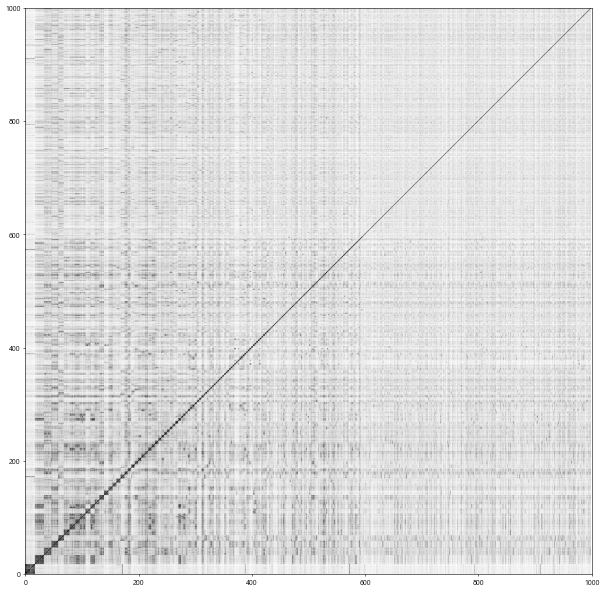

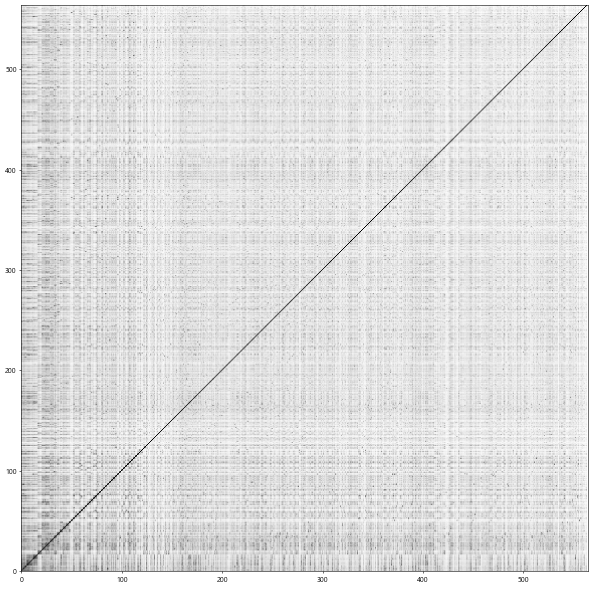

In [16]:
from soyclustering import merge_close_clusters, visualize_pairwise_distance

cluster_centers = spherical_kmeans.cluster_centers_
fig_origin = visualize_pairwise_distance(cluster_centers, max_dist=.5, sort=True)

group_centers, groups = merge_close_clusters(cluster_centers, labels, max_dist=.5)
fig = visualize_pairwise_distance(group_centers, max_dist=.5, sort=True)

### - New cluster에 New laber 부여

In [17]:
def merge_label(label, group) :
    label_map = {}
    for i, l in enumerate(group) :
        for item in l :
            label_map[item] = i
    new_labels = [label_map[x] for x in label]
    new_labels = np.asarray(new_labels)
    return new_labels, label_map

In [18]:
print("merged group number : {}".format(len(groups)))
new_label, lmap = merge_label(labels, groups)

merged group number : 564


### - 각 군집의 키워드 추출
- 각 cluster 별로 weight 가 높은 candidates_topk 개의 후보 중에서 proportion keyword score 가 높은 topk 개의 단어가 cluster labels 로 선택

In [19]:
from soyclustering import proportion_keywords

group_kmeans_keywords = proportion_keywords(
    group_centers,
    new_label,
    index2word=[tfidf_words[i] for i in idx_words],
    topk=30,
    candidates_topk=100
)

### - 200차원 pyLDAvis 시각화
- PSNE 방식으로 200차원을 2차원으로 시각화하여 각 군집별 키워드를 HTML형식으로 보여줌

In [250]:
sys.path.insert(0, "/Users/medici/Desktop/clustering4docs-master/kmeans_to_pyLDAvis")
import pyLDAvis
from kmeans_to_pyLDAvis import kmeans_to_prepared_data

num_cluster = 200
index2word=[tfidf_words[i] for i in idx_words]
_vis_idx = [e for e, x in enumerate(new_label) if x < num_cluster]
tfidf_vec_vis = tfidf_vec_c[_vis_idx]
new_label_vis = new_label[_vis_idx]

prepared_data = kmeans_to_prepared_data(
    tfidf_vec_vis, index2word, group_centers[:num_cluster], new_label_vis,
    embedding_method='tsne'
)

pyLDAvis.save_html(prepared_data, 'spherical_kmeans_vis_1112.html')
pyLDAvis.display(prepared_data)

In [20]:
topic_avg = sorted([(e, x) for e, x in enumerate(np.average(news_sum_dict['200'], axis = 0))], key = lambda x : -x[1])
topic_avg_idx = [x[0] for x in topic_avg[:10]]
print(topic_avg_idx)

[34, 15, 25, 35, 41, 21, 47, 3, 22, 27]


### - 각 차원별 코사인 유사도 구하기 (50, 100, 200, 300)
- 차원별 모델링 테스트를 하기 위함

In [22]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

tpvec_50 = cosine_similarity(tfidf_vec_c.toarray(), group_centers[:50])
tpvec_100 = cosine_similarity(tfidf_vec_c.toarray(), group_centers[:100])
tpvec_200 = cosine_similarity(tfidf_vec_c.toarray(), group_centers[:200])
tpvec_300 = cosine_similarity(tfidf_vec_c.toarray(), group_centers[:300])

Wall time: 11min 5s


In [21]:
def get_iso_week(dt) :
    iso = dt.isocalendar()
    y = iso[0]
    w = iso[1]
    s = "{}-{:02d}".format(int(y), int(w))
    return s

def get_past_weeks(dt) :
    res = []
    for i in range(1, 5) :
        past_dt = dt + relativedelta(weeks=-i)
        past_iso = past_dt.isocalendar()
        res.append("{}-{}".format(past_iso.year, past_iso.week))
    return res

In [22]:
tpvec_dict = {'50' : tpvec_50, '100' : tpvec_100, '200' : tpvec_200, '300' : tpvec_300}

In [23]:
news_arrays_dict = {k : {} for k in tpvec_dict.keys()}
for i, item in enumerate(news_raw) :
    dt = datetime.strptime(str(item[0]), "%Y%m%d")
    week = get_iso_week(dt)
    for k, v in tpvec_dict.items() :
        arr = news_arrays_dict[k].get(week, np.zeros(int(k)))
        news_arrays_dict[k][week] = np.sum([arr, v[i]], axis = 0)

In [24]:
news_arrays_dict['200']['2012-50']

array([18.28683937, 21.7077906 ,  9.93948815, 26.82427764, 19.09493056,
       19.37296083, 20.30821568, 12.3734048 , 23.49587956, 20.26857946,
       26.84507975,  8.81719184, 17.18511711,  9.46050885, 15.14880616,
       27.70113676, 13.52608521, 21.12377283, 24.386956  , 18.00692922,
       15.79312778, 25.29051717, 26.7548538 ,  8.4187337 , 13.70941717,
       27.34540624, 23.88056384, 24.76404781, 24.43968411, 22.03867689,
       15.44586385,  7.16420999, 25.18465643,  7.91221567, 30.51805761,
       25.95009723, 10.5235319 , 11.76330128, 22.20130698, 23.71860991,
       19.85082692, 27.13860487, 12.86210802, 19.75722436, 12.95381178,
       18.70295204, 17.44543234, 25.25015506, 17.89145619,  5.55139609,
        8.95745401, 19.58548539, 13.24907135, 20.44679632, 19.34701915,
       16.67425369, 22.84917007, 21.37840964, 21.83379678, 12.06624977,
       10.51069335, 17.41543682, 13.20321955, 10.61383745, 22.28680757,
        8.70912343, 10.23923767,  9.89217728, 17.58366077, 23.06

In [25]:
news_arrays_num = Counter()
news_arrays_num.update([get_iso_week(datetime.strptime(str(item[0]), "%Y%m%d")) for item in news_raw])

In [26]:
news_arrays_dict['50']['2013-17']

array([20.29234731, 25.56199347, 13.85194046, 34.061428  , 28.60226102,
       24.21852173, 31.19742073, 16.60238517, 35.58406465, 27.85825389,
       31.90675689, 11.2744051 , 18.92421645, 12.49439997, 17.45501412,
       39.43490316, 16.68454596, 24.03535417, 28.91372032, 21.70447394,
       18.61055746, 36.43291874, 32.18343366,  9.16331733, 17.37483007,
       32.96646154, 30.63752291, 34.15344536, 35.51719641, 30.6021512 ,
       17.39705068, 10.13740935, 29.39703065,  8.8086632 , 41.43174037,
       38.47841691, 15.30968807, 15.92434764, 28.16195956, 31.08361034,
       26.0302189 , 32.88059354, 16.50264886, 23.87988297, 15.61568578,
       22.75553677, 19.01583049, 37.00131099, 24.23681475,  6.53109496])

## 1.2) train set 종속변수 구성

### - 아파트매매가격지수 호출

In [27]:
df_pi = pd.read_excel('../data/아파트매매가격지수.xlsx', header = 1)
cols_all = ['구분', '서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기', '강원', '충북', '충남', '경북', '경남', '전북', '전남', '제주/\n서귀포']
name_dist = cols_all[1:]
df_pi = df_pi[cols_all]
apt_index = {}

for row in df_pi.itertuples(index = False) :
    w = get_iso_week(row.구분)
    apt_index[w] = {x : row[e+1] for e, x in enumerate(name_dist)}

In [28]:
index = sorted(news_arrays_dict['50'].keys(), key = lambda x : x)
    
for idx_b, idx, idx_a in zip(index, index[1:], index[2:]) :
    target = apt_index.get(idx, {})
    target_after = apt_index.get(idx_a, {})
    if not target :
        if not target_after :
            apt_index[idx] = apt_index[idx_b]
        else :
            apt_index[idx] = {k : (v + target_after[k])/2 for k,v in apt_index[idx_b].items()}

apt_origin = apt_index[index[0]]

apt_index_d = {index[0] : {k : 0.0 for k in apt_origin.keys()}}
apt_index_wr = {index[0] : {k : 0.0 for k in apt_origin.keys()}}


def make_price_label(v) :
    if v > 0 :
        return 1
    else :
        return 0

for idx, idx_next in zip(index, index[1:]) :
    d = apt_index[idx]
    d_next = apt_index[idx_next]
    apt_index_d[idx_next] = {k : round((v - d[k])/d[k] * 100, 8) for k, v in d_next.items()}
    #apt_index_d[idx_next] = {k : (v - d[k])/d[k] * 100 for k, v in d_next.items()}
    apt_index_wr[idx_next] = {k : make_price_label((v - d[k])/d[k]) for k, v in d_next.items()}

## 2.1) test set 입력변수 구성

In [60]:
df_test['words'][0]

['대전',
 '세종',
 '아파트',
 '가구',
 '분양',
 '내년',
 '광장',
 '대전',
 '세종',
 '충남',
 '민영',
 '아파트',
 '분양',
 '물량',
 '가구',
 '예측',
 '부동산정보업체',
 '집계',
 '물량',
 '민영',
 '아파트',
 '분양',
 '대전',
 '충남',
 '가구',
 '세종',
 '가구',
 '전국',
 '내년',
 '광장',
 '분양',
 '물량',
 '광장',
 '입주',
 '정도',
 '청약',
 '가점',
 '무주택자들',
 '매수',
 '상승',
 '집값']

In [61]:
newstest_ts = []
selected_words = list(idx2token.values())
tokenvec_dim = len(idx2token)

for row in df_test.itertuples(index = False) :
    words = row.words
    c = Counter()
    c.update(words)
    tfvec = np.zeros(tokenvec_dim)
    words = {k : v for k, v in c.items() if k in selected_words}
    for word, count in words.items() :
        np.put(tfvec, selected_words.index(word), count)
    newstest_ts.append((str(row.published_at), row.title, tfvec))

In [62]:
newstest_ts[0][0]

'2021-01-01 00:00:00'

In [63]:
tpvec_test = cosine_similarity([item[2] for item in newstest_ts], group_centers[:200])

## 2.2) test set 종속변수 구성

In [58]:
index_test = sorted(news_arrays_test.keys(), key = lambda x : x)
     
for idx_b, idx, idx_a in zip(index_test, index_test[1:], index_test[2:]) :
    target = apt_index.get(idx, {})
    target_after = apt_index.get(idx_a, {})
    if not target :
        if not target_after :
            apt_index[idx] = apt_index[idx_b]
        else :
            apt_index[idx] = {k : (v + target_after[k])/2 for k,v in apt_index[idx_b].items()}

            apt_index_test = {k : v for k,v in apt_index.items() if k in index_model_test}
apt_index_test_d = {}
apt_index_test_wr = {}


def make_price_label(v) :
    if v > 0 :
        return 1
    else :
        return 0

for idx, idx_next in zip(['2021-03'] + index_model_test, index_model_test) :
    d = apt_index[idx]
    d_next = apt_index[idx_next]
    apt_index_test_d[idx_next] = {k : round((v - d[k])/d[k] * 100, 8) for k, v in d_next.items()}
    #apt_index_test_d[idx_next] = {k : (v - d[k])/d[k] * 100 for k, v in d_next.items()}
    apt_index_test_wr[idx_next] = {k : make_price_label((v - d[k])/d[k]) for k, v in d_next.items()}

# 4. NEWS Title 대상 감성분석
- 비지도학습 : 군산대 감성사전 + 부동산 도메인 감성사전 적용

## 1) (1차) 긍부정 라벨링 감성분석

In [13]:
def score(x) :
    if x == '부정' :
        return -1
    elif x == '긍정' :
        return 1
    else :
        return 0
    
# title topic top1000개 감성라벨링한 파일
df_words = pd.read_csv('../2. 데이터 모델링/news_title_top1000_pos_neg.csv', encoding = 'euc-kr')
df_words = df_words.fillna(0)

df_words['score'] = [score(x) for x in df_words['통일']]
df_words.head(20)

Unnamed: 0      0      1 sj_긍부정 yj_긍부정  통일  score
0            0     거래  16134      0      0   0      0
1            1    아파트  14114      0      0   0      0
2            2    부동산  13368      0      0   0      0
3            3     전용  13144      0      0   0      0
4            4  서울특별시   9921      0      0   0      0
5            5     서울   7857      0      0   0      0
6            6     분양   7305      0      0   0      0
7            7     올라   7178     긍정     긍정  긍정      1
8            8     집값   6490      0      0   0      0
9            9     주택   5633      0      0   0      0
10          10     시장   5239      0      0   0      0
11          11     내려   4905     부정     부정  부정     -1
12          12     규제   4033     부정     부정  부정     -1
13          13     강남   3949      0      0   0      0
14          14     대책   3722      0      0   0      0
15          15     단지   3611      0      0   0      0
16          16     평균   3267      0      0   0      0
17          17     정부   2999      0      0   0      0
18          18     청약   2988      ?      0   0      0
19          19     전세   2844      0      0   0      0

In [14]:
senti_dict_domain = {k : v for k, v in zip(df_words['0'], df_words['score'])}

## 2) (2차) [군산대 감성사전] 감성분석

In [16]:
#군산대학교 감성사전 : http://dilab.kunsan.ac.kr/knusl.html 
with open("../2. 데이터 모델링/KnuSentiLex-master/KnuSentiLex-master/data/SentiWord_info.json", encoding='utf-8-sig') as f :
    sentiwords = json.load(f)
    f.close()

In [17]:
sentiword_dict_K = {x['word'] : (int(x['polarity']) * 0.25) for x in sentiwords}

In [18]:
# 1차, 2차 감성분석 결합
sentiword_dict = dict(senti_dict_domain.items( ) | sentiword_dict_K.items( ) )   

## 3) [OpenKoreanText] 부동산 도메인 감성분석

In [19]:
from konlpy.tag import Okt
t = Okt()

def senti_score(sent) :
    tokens = t.morphs(sent)
    scores = [sentiword_dict.get(x, 0) for x in tokens]
    #print(tokens)
    #print(scores)
    return sum(scores)

- train

In [21]:
df_train = pd.read_pickle('../2. 데이터 모델링/최종/df_train.pkl')

In [22]:
title_senti = [(x, senti_score(x)) for x in df_train['title']]

- test

In [80]:
title_senti_test = [(x, senti_score(x)) for x in df_test['title']]

## 4) 결과확인

In [25]:
# 감성지수 내림차순 정렬
sorted(title_senti, key = lambda x : -x[1])[:5]

[('초저금리 시대에 매월 안정적인 수익과 환금성이 높은 수익형 오피스텔 인기 급증', 5.25),
 ('초저금리 시대에 매월 안정적인 수익과 환금성이 높은 수익형 오피스텔 인기 급증!', 5.25),
 ('낙찰가율 70%벽 돌파 토지 경매시장 고공행진 재개발 재건축도 꿈틀', 5),
 ("'재건축 연한 단축'호재에 1980년대 아파트 인기 낙찰가율 급등", 5),
 ("서울 도심 재개발 재건축 아파트에 관심 몰려 '북한산 더샵’ 분양 인기 상승", 5)]

In [27]:
# 감성지수 오름차순 정렬
sorted(title_senti, key = lambda x : x[1])[:5]

[('탈세 편법대출 난무 9억 이상 고가주택 불법거래 811건', -6),
 ("[정부 부동산 규제 가시화] 부산 부동산, 금리 인상 대출 규제 투기 지구 '3각 파도'에 기 꺾일까", -5.5),
 ('금리인상 악재 현실화된 부동산시장 하락세 심화 우려', -5.5),
 ("'풍선효과' 우려없나...고가 다주택자 대출규제 없어 한계도", -5.25),
 ('대출규제로 거래심리 ‘꽁꽁’ 신도시 분양권 웃돈 반토막', -5)]

# 5. 최종 변수 set 생성

## 1) 각 차원에 감성지수 추가작업 
- 201차원

In [38]:
news_sum_dict = {k : [] for k in tpvec_dict.keys()}
index_model = index[4:]

for i, week in enumerate(index) :
    if i > 3 : 
        weeks = index[i-4:i]
        for k, d in news_sum_dict.items() :
            senti_sum = np.mean([news_title_senti[w] for w in weeks])
            sum1 = np.sum([news_arrays_dict[k][w] for w in weeks], axis = 0)
            d.append(np.append(sum1, senti_sum))

## 2) Train 입력변수 최종
- 4주 합계 : 4주 전부터 금주까지 문서별 벡터 합계
- 4주 평균 : 1개월치 문서별 벡터값의 합계  /  1개월치  문서 수
- 1주 평균 : ∑ 1주치 문서별 벡터값의 평균값(1~4주 평균을 SUM함)

### - 4주 평균

In [40]:
news_arrays_num = Counter()
news_arrays_num.update([get_iso_week(datetime.strptime(str(item[0]), "%Y%m%d")) for item in news_raw])

In [43]:
news_sum_avg_200 = []

for i, week in enumerate(index) :
    if i > 3 : 
        weeks = index[i-4:i]
        senti_sum = np.mean([news_title_senti[w] for w in weeks])
        _news_num_weeks = sum([news_arrays_num[w] for w in weeks])
        sum1 = np.sum([news_arrays_dict['200'][w] for w in weeks], axis = 0) / _news_num_weeks
        news_sum_avg_200.append(np.append(sum1, senti_sum))

### - 1주 평균

In [44]:
news_sum_avg_w_200 = []

for i, week in enumerate(index) :
    if i > 3 : 
        weeks = index[i-4:i]
        senti_sum = np.mean([news_title_senti[w] for w in weeks])
        sum1 = np.sum([news_arrays_dict['200'][w] / news_arrays_num[w] for w in weeks], axis = 0)
        news_sum_avg_w_200.append(np.append(sum1, senti_sum))

## 2) Test 입력변수 최종

In [143]:
newstest_title_senti = {}
for i, item in enumerate(newstest_ts) :
    dt = datetime.strptime(item[0], "%Y-%m-%d %H:%M:%S")
    week = get_iso_week(dt)
    week_senti = newstest_title_senti.get(week, 0)
    newstest_title_senti[week] = sum([week_senti, title_senti_test[i][1]])

In [54]:
news_arrays_test = {}
news_arrays_num_test = Counter()
for i, item in enumerate(newstest_ts) :
    dt = datetime.strptime(item[0], "%Y-%m-%d %H:%M:%S")
    week = get_iso_week(dt)
    arr = news_arrays_test.get(week, np.zeros(200))
    news_arrays_test[week] = np.sum([arr, tpvec_test[i]], axis = 0)
    news_arrays_num_test.update([week])

In [56]:
news_sum_test_200 = []
news_sum_test_avg_200 = []
news_sum_test_avg_w_200 = []
index_test = sorted(news_arrays_test.keys(), key = lambda x : x)
index_model_test = index_test[4:]

for i, week in enumerate(index_test) :
    if i > 3 : 
        weeks = index_test[i-4:i]
        senti_sum = np.mean([newstest_title_senti[w] for w in weeks])
        sum1 = np.sum([news_arrays_test[w] for w in weeks], axis =0)
        news_sum_test_200.append(np.append(sum1, senti_sum))
        sum2 = np.sum([news_arrays_test[w] / news_arrays_num_test[w] for w in weeks], axis = 0)
        news_sum_test_avg_w_200.append(np.append(sum2, senti_sum))
        _news_num_weeks = sum([news_arrays_num_test[w] for w in weeks])
        sum3 = np.sum([news_arrays_test[w] for w in weeks], axis = 0) / _news_num_weeks
        news_sum_test_avg_200.append(np.append(sum3, senti_sum))

# 6. Modeling
- 독립변수 -> 4주합계, 4주평균, 1주평균
- 종속변수 -> 매매지수, 직전 주와 해당주 매매지수의 변동률(편차)로 생성
- 다양한 예측모델 사용

## 1) 각 차원별 모델학습 (50,100,200,300)
- 입력변수 : 4주 합계

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost

model_res_dict = {}

for k, X in news_sum_dict.items() :
    outputs = {}
    lm_dict = {}
    xgboost_dict = {}
    lm_dict_d = {}
    xgboost_dict_d = {}
    lrm_dict = {}
    print("Training model - {} dim vectors".format(k))
    x_train, x_test = train_test_split(X, test_size=0.25, shuffle=True, random_state=42)
    df_xtrain = pd.DataFrame(x_train)
    df_xtest = pd.DataFrame(x_test)

    for city in name_dist :
        res = {}
        res_d = {}

        y = [apt_index[i][city] for i in index_model]
        y_d = [apt_index_d[i][city] for i in index_model]
        y_wr = [apt_index_wr[i][city] for i in index_model]

        y_train, y_test = train_test_split(y, test_size=0.25, shuffle=True, random_state=42)
        y_d_train, y_d_test = train_test_split(y_d, test_size=0.25, shuffle=True, random_state=42)
        y_wr_train, y_wr_test = train_test_split(y_wr, test_size=0.25, shuffle=True, random_state=42)

        lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None)
        lm.fit(x_train, y_train)
        lm_d = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None)
        lm_d.fit(x_train, y_d_train)
        lrm = LogisticRegression(max_iter = 10000)
        lrm.fit(x_train, y_wr_train)

        xgb_model = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,
                               colsample_bytree=1, max_depth=5)
        xgb_model.fit(df_xtrain, y_train)
        xgb_model_d = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,
                               colsample_bytree=1, max_depth=5)
        xgb_model_d.fit(df_xtrain, y_d_train)

        res['regression'] = {'accuracy' : lm.score(x_test, y_test),
                             'features' : lm.coef_}
        res['xgboost'] = {'accuracy' : xgb_model.score(df_xtest, y_test),
                           'features' : xgb_model.feature_importances_}
        res['LogisticRegression'] = {'accuracy' : lrm.score(x_test, y_wr_test),
                                     'features' : lrm.coef_}

        res_d['regression'] = {'accuracy' : lm_d.score(x_test, y_d_test),
                             'features' : lm_d.coef_}
        res_d['xgboost'] = {'accuracy' : xgb_model_d.score(df_xtest, y_d_test),
                           'features' : xgb_model_d.feature_importances_}

        #outputs[city] = {'price_index' : res, 'price_index_d' : res_d}
        outputs[city] = {'lm' : res['regression'], 'lm_d' : res_d['regression'],
                         'lrm' : res['LogisticRegression'], 'xgboost' : res['xgboost'], 
                         'xgboost_d' : res_d['xgboost']}
        lm_dict[city] = lm
        xgboost_dict[city] = xgb_model
        lrm_dict[city] = lrm
        lm_dict_d[city] = lm_d
        xgboost_dict_d[city] = xgb_model_d
        
    model_res_dict[k] = {'outputs' : outputs, 'lm' : lm_dict, 'lm_d' : lm_dict_d,
                         'lrm' : lrm_dict, 'xgboost' : xgboost_dict, 'xgboost_d' : xgboost_dict_d}

Training model - 50 dim vectors
Training model - 100 dim vectors
Training model - 200 dim vectors
Training model - 300 dim vectors


### - 차원별 accuracy 확인

In [44]:
key_v = ['50', '100', '200', '300']
key_city = ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기', '강원', '충북', '충남', '경북', '경남', '전북', '전남', '제주/\n서귀포']
key_model = ['lm', 'xgboost', 'lrm', 'lm_d', 'xgboost_d']

for _city in key_city :
    print(_city)
    for _model in key_model :
        print(_model)
        print('   '.join(["vec {:<6}".format(_v) for _v in key_v]))
        print(' | '.join(["{:.8f}".format(model_res_dict[_v]['outputs'][_city][_model]['accuracy']) for _v in key_v]))

서울
lm
vec 50       vec 100      vec 200      vec 300   
0.66354347 | 0.76626246 | 0.78951372 | 0.75731674
xgboost
vec 50       vec 100      vec 200      vec 300   
0.61737405 | 0.60183221 | 0.59229098 | 0.61510216
lrm
vec 50       vec 100      vec 200      vec 300   
0.72027972 | 0.76223776 | 0.83916084 | 0.88111888
lm_d
vec 50       vec 100      vec 200      vec 300   
0.26377535 | 0.42878951 | 0.22042765 | 0.31743412
xgboost_d
vec 50       vec 100      vec 200      vec 300   
0.44010408 | 0.48363155 | 0.46793250 | 0.48362853
부산
lm
vec 50       vec 100      vec 200      vec 300   
0.28204904 | 0.41817044 | 0.58599917 | 0.67688861
xgboost
vec 50       vec 100      vec 200      vec 300   
0.31014280 | 0.40112971 | 0.35384757 | 0.40006403
lrm
vec 50       vec 100      vec 200      vec 300   
0.81818182 | 0.85314685 | 0.88111888 | 0.89510490
lm_d
vec 50       vec 100      vec 200      vec 300   
0.28151936 | 0.44418065 | 0.57024365 | 0.34150861
xgboost_d
vec 50       vec 100      vec 200 

### - 200차원 feature importances Heatmap 확인

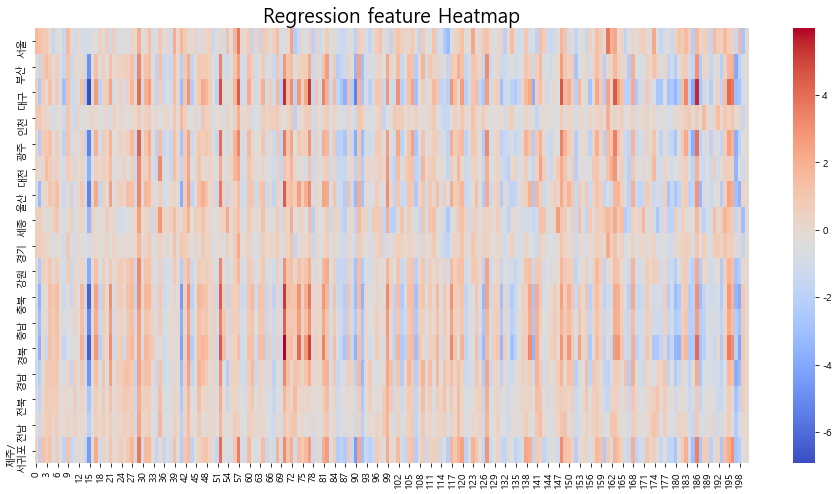

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

df_regression_feature = pd.DataFrame([model_res_dict['200']['outputs'][_city]['lm']['features'] for _city in key_city], index = key_city)

plt.figure(figsize = (16,8))

sns.heatmap(df_regression_feature, cmap='coolwarm')
plt.title('Regression feature Heatmap', fontsize=20)
plt.show()

## 2) 4주 평균에 대한 모델학습 

In [50]:
avg_model_res_dict = {}

X = news_sum_avg_200
outputs = {}
lm_dict = {}
xgboost_dict = {}
lm_dict_d = {}
xgboost_dict_d = {}
lrm_dict = {}
x_train, x_test = train_test_split(X, test_size=0.25, shuffle=True, random_state=42)
df_xtrain = pd.DataFrame(x_train)
df_xtest = pd.DataFrame(x_test)

for city in name_dist :
    res = {}
    res_d = {}

    y = [apt_index[i][city] for i in index_model]
    y_d = [apt_index_d[i][city] for i in index_model]
    y_wr = [apt_index_wr[i][city] for i in index_model]

    y_train, y_test = train_test_split(y, test_size=0.25, shuffle=True, random_state=42)
    y_d_train, y_d_test = train_test_split(y_d, test_size=0.25, shuffle=True, random_state=42)
    y_wr_train, y_wr_test = train_test_split(y_wr, test_size=0.25, shuffle=True, random_state=42)

    lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None)
    lm.fit(x_train, y_train)
    lm_d = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None)
    lm_d.fit(x_train, y_d_train)
    lrm = LogisticRegression(max_iter = 10000)
    lrm.fit(x_train, y_wr_train)

    xgb_model = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=5)
    xgb_model.fit(df_xtrain, y_train)
    xgb_model_d = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=5)
    xgb_model_d.fit(df_xtrain, y_d_train)

    res['regression'] = {'accuracy' : lm.score(x_test, y_test),
                         'features' : lm.coef_}
    res['xgboost'] = {'accuracy' : xgb_model.score(df_xtest, y_test),
                       'features' : xgb_model.feature_importances_}
    res['LogisticRegression'] = {'accuracy' : lrm.score(x_test, y_wr_test),
                                 'features' : lrm.coef_}

    res_d['regression'] = {'accuracy' : lm_d.score(x_test, y_d_test),
                         'features' : lm_d.coef_}
    res_d['xgboost'] = {'accuracy' : xgb_model_d.score(df_xtest, y_d_test),
                       'features' : xgb_model_d.feature_importances_}

    outputs[city] = {'lm' : res['regression'], 'lm_d' : res_d['regression'],
                     'lrm' : res['LogisticRegression'], 'xgboost' : res['xgboost'], 
                     'xgboost_d' : res_d['xgboost']}
    lm_dict[city] = lm
    xgboost_dict[city] = xgb_model
    lrm_dict[city] = lrm
    lm_dict_d[city] = lm_d
    xgboost_dict_d[city] = xgb_model_d

avg_model_res_dict['200'] = {'outputs' : outputs, 'lm' : lm_dict, 'lm_d' : lm_dict_d,
                     'lrm' : lrm_dict, 'xgboost' : xgboost_dict, 'xgboost_d' : xgboost_dict_d}

## 3) 1주 평균에 대한 모델학습

In [51]:
avg_w_model_res_dict = {}

X = news_sum_avg_w_200
outputs = {}
lm_dict = {}
xgboost_dict = {}
lm_dict_d = {}
xgboost_dict_d = {}
lrm_dict = {}
x_train, x_test = train_test_split(X, test_size=0.25, shuffle=True, random_state=42)
df_xtrain = pd.DataFrame(x_train)
df_xtest = pd.DataFrame(x_test)

for city in name_dist :
    res = {}
    res_d = {}

    y = [apt_index[i][city] for i in index_model]
    y_d = [apt_index_d[i][city] for i in index_model]
    y_wr = [apt_index_wr[i][city] for i in index_model]

    y_train, y_test = train_test_split(y, test_size=0.25, shuffle=True, random_state=42)
    y_d_train, y_d_test = train_test_split(y_d, test_size=0.25, shuffle=True, random_state=42)
    y_wr_train, y_wr_test = train_test_split(y_wr, test_size=0.25, shuffle=True, random_state=42)

    lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None)
    lm.fit(x_train, y_train)
    lm_d = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None)
    lm_d.fit(x_train, y_d_train)
    lrm = LogisticRegression(max_iter = 10000)
    lrm.fit(x_train, y_wr_train)

    xgb_model = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=5)
    xgb_model.fit(df_xtrain, y_train)
    xgb_model_d = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=5)
    xgb_model_d.fit(df_xtrain, y_d_train)

    res['regression'] = {'accuracy' : lm.score(x_test, y_test),
                         'features' : lm.coef_}
    res['xgboost'] = {'accuracy' : xgb_model.score(df_xtest, y_test),
                       'features' : xgb_model.feature_importances_}
    res['LogisticRegression'] = {'accuracy' : lrm.score(x_test, y_wr_test),
                                 'features' : lrm.coef_}

    res_d['regression'] = {'accuracy' : lm_d.score(x_test, y_d_test),
                         'features' : lm_d.coef_}
    res_d['xgboost'] = {'accuracy' : xgb_model_d.score(df_xtest, y_d_test),
                       'features' : xgb_model_d.feature_importances_}

    outputs[city] = {'lm' : res['regression'], 'lm_d' : res_d['regression'],
                     'lrm' : res['LogisticRegression'], 'xgboost' : res['xgboost'], 
                     'xgboost_d' : res_d['xgboost']}
    lm_dict[city] = lm
    xgboost_dict[city] = xgb_model
    lrm_dict[city] = lrm
    lm_dict_d[city] = lm_d
    xgboost_dict_d[city] = xgb_model_d

avg_w_model_res_dict['200'] = {'outputs' : outputs, 'lm' : lm_dict, 'lm_d' : lm_dict_d,
                     'lrm' : lrm_dict, 'xgboost' : xgboost_dict, 'xgboost_d' : xgboost_dict_d}

## 4) 각 입력변수에 대한 accuracy 확인

In [230]:
for _city in key_city :
    print(_city)
    for _model in key_model :
        print(_model)
        _avg = avg_model_res_dict['200']['outputs'][_city][_model]['accuracy']
        _avg_w = avg_w_model_res_dict['200']['outputs'][_city][_model]['accuracy']
        _origin = model_res_dict['200']['outputs'][_city][_model]['accuracy']
        print('   '.join(["{:<9}".format(_n) for _n in ["기본", "평균_4주", "평균_1주"]]))
        print(' | '.join(["{:.8f}".format(_acc) for _acc in [_origin, _avg, _avg_w]]))
    print()

서울
lm
기본          평균_4주       평균_1주    
0.78951372 | 0.98391509 | 0.99005252
xgboost
기본          평균_4주       평균_1주    
0.59229098 | 0.95169732 | 0.98715251
lrm
기본          평균_4주       평균_1주    
0.83916084 | 0.74125874 | 0.92307692
lm_d
기본          평균_4주       평균_1주    
0.22042765 | 0.76630229 | 0.76290172
xgboost_d
기본          평균_4주       평균_1주    
0.46793250 | 0.82732233 | 0.81617264

부산
lm
기본          평균_4주       평균_1주    
0.58599917 | 0.96131214 | 0.97669240
xgboost
기본          평균_4주       평균_1주    
0.35384757 | 0.88793871 | 0.93568144
lrm
기본          평균_4주       평균_1주    
0.88111888 | 0.80419580 | 0.84615385
lm_d
기본          평균_4주       평균_1주    
0.57024365 | 0.81444474 | 0.83750112
xgboost_d
기본          평균_4주       평균_1주    
0.50896854 | 0.81473854 | 0.86727306

대구
lm
기본          평균_4주       평균_1주    
0.58984118 | 0.98163145 | 0.99218437
xgboost
기본          평균_4주       평균_1주    
0.51517394 | 0.93580625 | 0.96888821
lrm
기본          평균_4주       평균_1주    
0.89510490 | 0.86013986 | 0.

# 7. test 예측

## 1) test model 생성

In [59]:
test_model = {'origin' : {'models' : model_res_dict['200'], 'input' : news_sum_test_200},
              'avg' : {'models' : avg_model_res_dict['200'], 'input' : news_sum_test_avg_200}, 
              'avg_w' : {'models' : avg_w_model_res_dict['200'], 'input' : news_sum_test_avg_w_200}
             }

model_res_test = {}

for res_name, res_dict in test_model.items() :
    test_input = res_dict['input']
    _res = {}
    for model_k, model_v in res_dict['models'].items() :
        _res_model = {}
        if model_k == 'outputs' :
            continue
        
        if model_k.find('xgboost') >= 0 :
            x_newtest = pd.DataFrame(test_input)
        else :
            x_newtest = test_input
        
        if model_k.find('_d') >= 0 :
            y_apttest = apt_index_test_d
        elif model_k.find('lrm') >= 0 :
            y_apttest = apt_index_test_wr
        else :
            y_apttest = apt_index_test
        
        for si, m in model_v.items() :
            y_newtest = [v[si] for k, v in sorted(y_apttest.items(), key = lambda x : x[0])]
            testscore = m.score(x_newtest, y_newtest)
            prediction = m.predict(x_newtest)
            _res_model[si] = {'score' : testscore, 'predict' : prediction}
        _res[model_k] = _res_model
    model_res_test[res_name] = _res

## 2) test model Score 확인

In [60]:
#score
models = list(model_res_test['origin'].keys())
for m in models :
    print(m)
    print("city\t\torigin\t\tavg(4w)\t\tavg(1w)")
    for _city in key_city :
        s_origin = model_res_test['origin'][m][_city]['score']
        s_avg = model_res_test['avg'][m][_city]['score']
        s_avg_w = model_res_test['avg_w'][m][_city]['score']
        print("{}\t\t{:.8f}\t{:.8f}\t{:.8f}".format(_city, s_origin, s_avg, s_avg_w))
    print()

lm
city		origin		avg(4w)		avg(1w)
서울		-95.83714011	-42.78617400	-33.92603002
부산		-561.07744540	-29.01684912	-38.99822711
대구		-645.06191958	-72.24619813	-27.38778600
인천		-4.30367779	-6.40640653	-6.79948957
광주		-387.56360172	-34.85041565	-23.36539148
대전		-264.48447647	-27.19470893	-36.98374976
울산		-584.67475166	-50.95257458	-59.51533374
세종		-1149.82185941	-515.59027434	-519.33196311
경기		-11.12173451	-15.01964225	-16.39978696
강원		-190.52526702	-7.16324697	-10.68789034
충북		-303.46203942	-6.01438421	-6.64534704
충남		-257.18983635	-6.65044807	-2.83395260
경북		-1154.36117822	-8.94208817	0.14228857
경남		-1567.46706369	-21.25514623	-57.18829389
전북		-669.37298101	-5.95507664	-19.27082903
전남		-3777.21858359	-38.97027806	-97.34823082
제주/
서귀포		-126.80725579	-6.53038659	-7.01036514

lm_d
city		origin		avg(4w)		avg(1w)
서울		-1064.03869239	-1.85863188	-2.92346239
부산		-115.06516433	-13.34399969	-35.82045831
대구		-90.63887798	-7.24757929	-33.50476764
인천		-24.87702234	-7.80172746	-4.71077034
광주		-168.11647184

### - 실제 값과 예측 치의 차이 비교

In [61]:
si = '서울'
y_real = [v[si] for k, v in sorted(apt_index_test_d.items(), key = lambda x : x[0])]
y_predict = model_res_dict['200']['xgboost_d'][si].predict(pd.DataFrame(news_sum_test_200))
y_predict_avg = avg_model_res_dict['200']['xgboost_d'][si].predict(pd.DataFrame(news_sum_test_avg_200))
y_predict_avg_w = avg_w_model_res_dict['200']['xgboost_d'][si].predict(pd.DataFrame(news_sum_test_avg_w_200))

print("실제\t\t예측\t\t예측(4주평균)\t예측(1주평균)")
for (r, p, ps, pa) in zip(y_real, y_predict, y_predict_avg, y_predict_avg_w) :
    print("{:.8f}\t{:.8f}\t{:.8f}\t{:.8f}".format(r, p, ps, pa))
    
    
models = list(model_res_test['origin'].keys())
for m in models :
    print(m)
    print("city\t\torigin\t\tavg(4w)\t\tavg(1w)")
    for _city in key_city :
        s_origin = model_res_test['origin'][m][_city]['score']
        s_avg = model_res_test['avg'][m][_city]['score']
        s_avg_w = model_res_test['avg_w'][m][_city]['score']
        print("{}\t\t{:.8f}\t{:.8f}\t{:.8f}".format(_city, s_origin, s_avg, s_avg_w))
    print()

실제		예측		예측(4주평균)	예측(1주평균)
0.37550517	0.69409811	0.28851923	0.92772692
0.40092824	0.86395687	0.27842045	0.92772692
0.21201495	0.85387975	0.28098702	0.93441010
0.21156639	0.84764820	0.26871851	0.92753762
0.38023374	0.75145656	0.30379719	0.92747927
0.34168899	0.87292129	0.28512654	0.93398243
0.32125844	0.52779490	0.26242408	0.92298514
0.28194444	0.24967803	0.27616903	0.92749846
0.24496512	0.28479809	0.22157510	0.92259026
0.20216975	0.50658894	0.20186552	0.92450303
0.28457977	0.58621860	0.15016973	0.91940683
0.21685643	0.66360134	0.28357980	0.92407590
0.21589254	0.98647451	0.33004719	0.94576621
0.27569968	0.78685188	0.36411780	0.94574994
0.22734475	0.78614897	0.45099044	0.94574386
0.28489506	0.85102230	0.44999176	0.94610733
0.22325337	0.85550475	0.35044596	0.94636321
0.34536406	0.27822611	0.35076287	0.93471318
0.36553758	0.47054577	0.34993351	0.92740291
0.37980687	0.56618237	0.31301948	0.92744929
0.33471017	0.46261805	0.33830059	0.92760253
0.33597527	0.51957947	0.33543783	0.92772692
0.3989

## 3) 실제값과 예측값 시각화

In [62]:
index_model_test = [k.split('-')[1] for k, v in sorted(y_apttest.items(), key = lambda x : x[0])]

In [255]:
def predict_plot(si, model_name) :
    
    if model_name.find('_d') >= 0 :
        y_apttest = apt_index_test_d
    elif model_name.find('lrm') >= 0 :
        y_apttest = apt_index_test_wr
    else :
        y_apttest = apt_index_test
        
    #index_model_test = [k for k, v in sorted(y_apttest.items(), key = lambda x : x[0])]
    
    actual = [v[si] for k, v in sorted(y_apttest.items(), key = lambda x : x[0])]
    d = [(x[0], x[1], 'actual') for x in zip(index_model_test, actual)]
    d2 = [(x[0], x[1], 'pred_origin') for x in zip(index_model_test, model_res_test['origin'][model_name][si]['predict'])]
    d3 = [(x[0], x[1], 'pred_avg') for x in zip(index_model_test, model_res_test['avg'][model_name][si]['predict'])]
    d4 = [(x[0], x[1], 'pred_avg_w') for x in zip(index_model_test, model_res_test['avg_w'][model_name][si]['predict'])]
    
    df = pd.DataFrame(d + d2 + d3 + d4, columns =['week', 'y', 'hue'])
    sns.set(rc={'figure.figsize':(14,10)})
    sns.lineplot(x='week', y='y', hue='hue', data=df,color = 'PuRd', linewidth = 2.5)
    
    return sns

<module 'seaborn' from 'C:\\Users\\medici\\anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

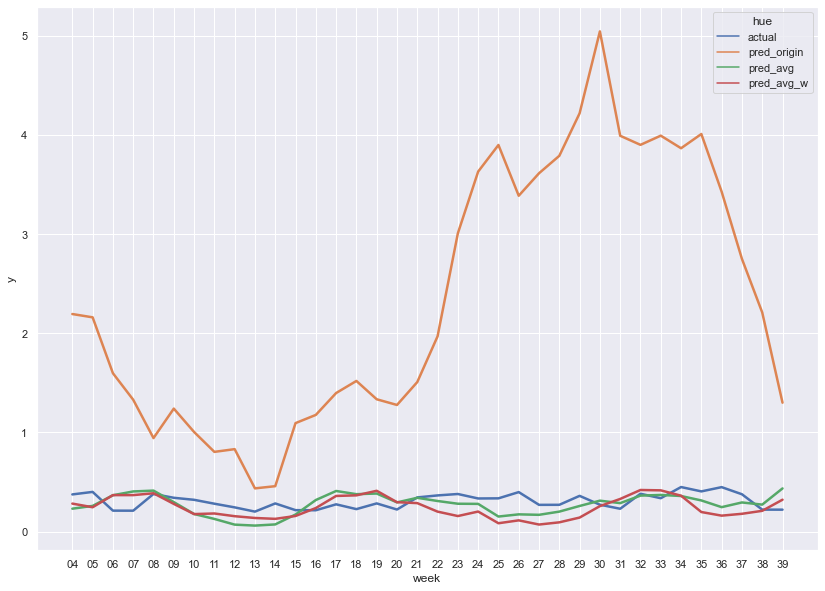

In [256]:
predict_plot('서울', 'lm_d')

## 4) RMSE 확인

In [287]:
from sklearn.metrics import mean_squared_error

models = list(model_res_test['origin'].keys())
for m in models :
    print(m)
    print("city\t\torigin\t\tavg(4w)\t\tavg(1w)")
    for _city in key_city :
        y_real = [v[_city] for k, v in sorted(apt_index_test_d.items(), key = lambda x : x[0])]
        y_predict = model_res_dict['200'][m][_city].predict(pd.DataFrame(news_sum_test_200))
        y_predict_avg = avg_model_res_dict['200'][m][_city].predict(pd.DataFrame(news_sum_test_avg_200))
        y_predict_avg_w = avg_w_model_res_dict['200'][m][_city].predict(pd.DataFrame(news_sum_test_avg_w_200))

        s_origin = np.sqrt(mean_squared_error(y_real, y_predict))
        s_avg = np.sqrt(mean_squared_error(y_real, y_predict_avg))
        s_avg_w = np.sqrt(mean_squared_error(y_real, y_predict_avg_w))
        print("{}\t\t{:.8f}\t{:.8f}\t{:.8f}".format(_city, s_origin, s_avg, s_avg_w))
    print()

lm
city		origin		avg(4w)		avg(1w)
서울		116.57487916	99.43998787	102.29916556
부산		62.88273711	93.43933902	90.08414365
대구		165.58958368	96.94398835	104.79541301
인천		121.45697542	100.41137122	99.81832595
광주		101.76327158	92.87359672	95.16817873
대전		75.65381887	105.45379780	101.51700282
울산		118.46906040	96.48352064	95.34168355
세종		99.99643535	112.82071184	113.59410803
경기		117.16998559	100.67986468	99.57910552
강원		96.36510659	91.96934917	90.02478444
충북		129.76636595	96.07106664	95.68254016
충남		133.93993783	97.67143672	100.22412718
경북		175.60465289	97.28171427	104.98461044
경남		70.92652276	94.61466159	88.61572948
전북		62.91348397	95.09414562	90.04626338
전남		58.48556464	97.95675450	94.22890259
제주/
서귀포		95.69349017	90.46200933	89.81194643

lm_d
city		origin		avg(4w)		avg(1w)
서울		2.40057401	0.12436882	0.14570255
부산		0.93937345	0.33023452	0.52909289
대구		0.96480100	0.28944171	0.59202142
인천		0.87620445	0.51101337	0.41161922
광주		1.30555960	0.55367325	0.29645299
대전		1.02183695	0.29644551	0.23449556
울산	

### - 경기&서울 4주평균 중요변수 Heatmap

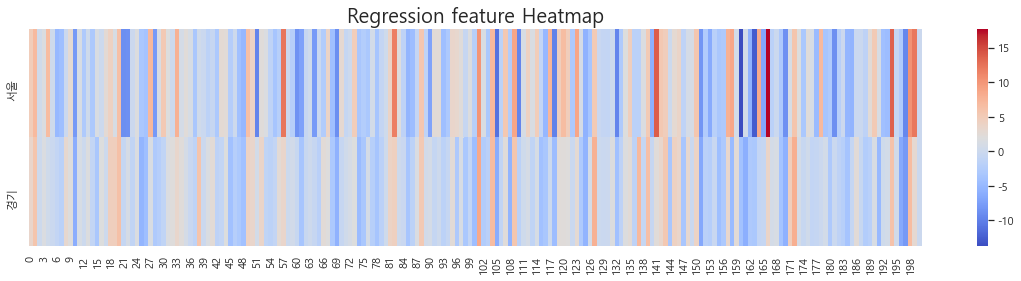

In [215]:
df_regression_feature = pd.DataFrame([avg_model_res_dict['200']['outputs'][_city]['lm_d']['features'] for _city in ["서울", "경기"]], index = ["서울", "경기"])

plt.figure(figsize = (20,4))

sns.heatmap(df_regression_feature, cmap='coolwarm')
plt.title('Regression feature Heatmap', fontsize=20)
plt.show()

### - featrue importances TOP 10

In [221]:
sorted([(e, x) for e, x in enumerate(avg_model_res_dict['200']['outputs']['서울']['lm_d']['features'])], key = lambda x : - abs(x[1]))[:11]

[(166, 17.70404710803181),
 (141, 13.9225724566836),
 (160, -13.75069811061255),
 (194, 13.70257483218619),
 (163, -12.61703413805036),
 (57, 12.398130757592291),
 (199, 12.251070264401962),
 (82, 11.740360916435801),
 (105, -10.998326342395895),
 (198, 10.386092204307248),
 (101, 10.207882324021377)]

In [218]:
sorted([(e, x) for e, x in enumerate(avg_model_res_dict['200']['outputs']['경기']['lm_d']['features'])], key = lambda x : - abs(x[1]))[:11]

[(101, 8.504344171812447),
 (172, 8.078388807417609),
 (197, -7.931209282061598),
 (127, 7.836796336160831),
 (137, 7.069944346965832),
 (198, 6.832018447472613),
 (104, 6.821999391665637),
 (151, -6.571610343590124),
 (196, -6.486222422365675),
 (139, 6.4468653915416025),
 (20, 6.302809319051043)]

# 8. 예측치 지도시각화

In [76]:
lm_re = {}
for si, lm in avg_w_model_res_dict['200']['lm_d'].items() :
    lm_re[si] = lm.predict(news_sum_test_avg_w_200).tolist()

In [78]:
pred_idx = df_pi['구분'][643:]

In [80]:
df_geo = pd.DataFrame(lm_re)
df_geo.head()

서울        부산        대구        인천        광주        대전        울산  \
0  0.283102 -0.077818 -0.212666  0.323953 -0.139377  0.232177 -0.349474   
1  0.246180 -0.065196 -0.235225  0.267629  0.023759  0.314540 -0.435164   
2  0.368539 -0.114608 -0.145097  0.306556  0.034488  0.326488 -0.373769   
3  0.368529 -0.025474  0.047796  0.263082  0.200215  0.338201 -0.293432   
4  0.387339 -0.010543  0.043951  0.238411  0.292904  0.390123 -0.269065   

         세종        경기        강원        충북        충남        경북        경남  \
0  0.865549  0.086560 -0.147784  0.163617 -0.249956  0.107496  0.148058   
1  1.300713  0.101752 -0.040130  0.093333 -0.237157  0.013643  0.133960   
2  1.449088  0.111727 -0.177996  0.094200 -0.307986  0.051282  0.133856   
3  1.275656  0.112939 -0.208759  0.153853 -0.371439  0.117137  0.112394   
4  1.196871  0.103468 -0.232098  0.033721 -0.447769  0.024357  0.071201   

         전북        전남  제주/\n서귀포  
0  0.015560 -0.166558  0.267624  
1  0.146737 -0.004962  0.253615  
2  0.122817  0.015566  0.223400  
3  0.060487  0.031640  0.128910  
4  0.060922  0.036949  0.120203

In [82]:
df_geo = pd.DataFrame(lm_re)
cols_all = ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기', '강원', '충북', '충남', '경북', '경남', '전북', '전남', '제주/\n서귀포']
df_geo = df_geo[cols_all]
df_geo.set_index(pred_idx, inplace=True)
df_geo.head()

서울        부산        대구        인천        광주        대전  \
구분                                                                       
2021-01-11  0.283102 -0.077818 -0.212666  0.323953 -0.139377  0.232177   
2021-01-18  0.246180 -0.065196 -0.235225  0.267629  0.023759  0.314540   
2021-01-25  0.368539 -0.114608 -0.145097  0.306556  0.034488  0.326488   
2021-02-01  0.368529 -0.025474  0.047796  0.263082  0.200215  0.338201   
2021-02-15  0.387339 -0.010543  0.043951  0.238411  0.292904  0.390123   

                  울산        세종        경기        강원        충북        충남  \
구분                                                                       
2021-01-11 -0.349474  0.865549  0.086560 -0.147784  0.163617 -0.249956   
2021-01-18 -0.435164  1.300713  0.101752 -0.040130  0.093333 -0.237157   
2021-01-25 -0.373769  1.449088  0.111727 -0.177996  0.094200 -0.307986   
2021-02-01 -0.293432  1.275656  0.112939 -0.208759  0.153853 -0.371439   
2021-02-15 -0.269065  1.196871  0.103468 -0.232098  0.033721 -0.447769   

                  경북        경남        전북        전남  제주/\n서귀포  
구분                                                            
2021-01-11  0.107496  0.148058  0.015560 -0.166558  0.267624  
2021-01-18  0.013643  0.133960  0.146737 -0.004962  0.253615  
2021-01-25  0.051282  0.133856  0.122817  0.015566  0.223400  
2021-02-01  0.117137  0.112394  0.060487  0.031640  0.128910  
2021-02-15  0.024357  0.071201  0.060922  0.036949  0.120203

In [83]:
df_geo.reset_index(inplace=True)

In [84]:
df_geo

구분        서울        부산        대구        인천        광주        대전  \
0  2021-01-11  0.283102 -0.077818 -0.212666  0.323953 -0.139377  0.232177   
1  2021-01-18  0.246180 -0.065196 -0.235225  0.267629  0.023759  0.314540   
2  2021-01-25  0.368539 -0.114608 -0.145097  0.306556  0.034488  0.326488   
3  2021-02-01  0.368529 -0.025474  0.047796  0.263082  0.200215  0.338201   
4  2021-02-15  0.387339 -0.010543  0.043951  0.238411  0.292904  0.390123   
5  2021-02-22  0.280044 -0.131183  0.069165  0.247656  0.081373  0.215079   
6  2021-03-01  0.177322 -0.172108 -0.031877  0.200733  0.059679  0.195872   
7  2021-03-08  0.183384 -0.272232 -0.299103  0.234595 -0.087833  0.073764   
8  2021-03-15  0.155983 -0.177688 -0.374241  0.227054 -0.066259  0.119689   
9  2021-03-22  0.138026 -0.121694 -0.483886  0.211762 -0.005706  0.121330   
10 2021-03-29  0.129244 -0.207835 -0.562086  0.177478 -0.030948  0.100471   
11 2021-04-05  0.158197 -0.187336 -0.604341  0.213200 -0.049042  0.173558   
12 2021-04-12  0.238274 -0.351135 -0.650974  0.269617 -0.116785  0.081838   
13 2021-04-19  0.360162 -0.367899 -0.721182  0.301845 -0.112796  0.038915   
14 2021-04-26  0.366233 -0.341107 -0.731661  0.280252 -0.042413  0.117627   
15 2021-05-03  0.412311 -0.336780 -0.725591  0.339713 -0.076630  0.165802   
16 2021-05-10  0.297302 -0.320560 -0.637858  0.252793 -0.072788  0.161237   
17 2021-05-17  0.287875 -0.196986 -0.503972  0.322461 -0.139168  0.187258   
18 2021-05-24  0.202025 -0.160841 -0.429199  0.361432 -0.165786  0.127834   
19 2021-05-31  0.157472 -0.256284 -0.407401  0.312655 -0.213269  0.068064   
20 2021-06-07  0.202851 -0.253455 -0.414989  0.347054 -0.233212  0.077583   
21 2021-06-14  0.084941 -0.342409 -0.451022  0.239399 -0.196011  0.094474   
22 2021-06-21  0.114031 -0.367752 -0.448133  0.188361 -0.113643  0.103299   
23 2021-06-28  0.071829 -0.294328 -0.416309  0.188005 -0.062209  0.138393   
24 2021-07-05  0.094150 -0.260595 -0.362511  0.168207 -0.014024  0.156180   
25 2021-07-12  0.142114 -0.232792 -0.338994  0.223803  0.025170  0.140659   
26 2021-07-19  0.257646 -0.157951 -0.253063  0.249870 -0.014047  0.179845   
27 2021-07-26  0.329846 -0.124309 -0.215309  0.217039 -0.025313  0.182178   
28 2021-08-02  0.420211 -0.120428 -0.260983  0.290066 -0.034332  0.242757   
29 2021-08-09  0.416719 -0.166099 -0.257019  0.266632 -0.039205  0.324933   
30 2021-08-16  0.362658 -0.095461 -0.099027  0.223049  0.225261  0.413911   
31 2021-08-23  0.198012 -0.068063 -0.097256  0.237312  0.267512  0.433224   
32 2021-08-30  0.161512 -0.024359 -0.098325  0.242988  0.306601  0.390422   
33 2021-09-06  0.180159  0.106374 -0.100069  0.304354  0.274941  0.366853   
34 2021-09-13  0.210171  0.041431 -0.302281  0.400093 -0.116048  0.201555   
35 2021-09-27  0.322293 -0.101569 -0.310378  0.410179 -0.229614  0.125723   

          울산        세종        경기        강원        충북        충남        경북  \
0  -0.349474  0.865549  0.086560 -0.147784  0.163617 -0.249956  0.107496   
1  -0.435164  1.300713  0.101752 -0.040130  0.093333 -0.237157  0.013643   
2  -0.373769  1.449088  0.111727 -0.177996  0.094200 -0.307986  0.051282   
3  -0.293432  1.275656  0.112939 -0.208759  0.153853 -0.371439  0.117137   
4  -0.269065  1.196871  0.103468 -0.232098  0.033721 -0.447769  0.024357   
5  -0.006294  0.588171  0.024193 -0.426875  0.102550 -0.475342  0.072023   
6  -0.039292  0.465356 -0.027379 -0.411140 -0.019891 -0.416338 -0.064477   
7  -0.321664  0.138747 -0.022164 -0.313106  0.150523 -0.321955 -0.033588   
8  -0.364359 -0.227384 -0.008698 -0.314398  0.314214 -0.202479 -0.011136   
9  -0.558943 -0.453111 -0.038901 -0.268863  0.404458 -0.160691  0.047072   
10 -0.776160 -0.703520 -0.094661 -0.243365  0.474216 -0.166053  0.059379   
11 -0.787077 -0.408471 -0.115348 -0.388138  0.302691 -0.199102  0.013072   
12 -0.794992  0.005732 -0.132903 -0.410599  0.159211 -0.283410  0.026029   
13 -0.766476  0.507548 -0.123516 -0.341152  0.100698 -0.376774 -0.034770   
14 -0.688364  0.65021

In [85]:
si_name = []
for si in cols_all:
    if si == '서울':
        si_name.append(si + '특별시')
    elif si == '부산' or si == '대구' or si == '인천' or si == '광주' or si == '대전' or si == '울산':
        si_name.append(si + '광역시')
    elif si == '세종':
        si_name.append(si + '특별자치시')
    elif si == '제주/\n서귀포':
        si_name.append('제주특별자치도')
    else:
        si = si + '도'
        if si[:2] == '경기' or si[:2] == '강원':
            si_name.append(si)
        elif si[0] == '충':
            si_name.append(si[0] + '청' + si[1:])
        elif si[0] == '전':
            si_name.append(si[0] + '라' + si[1:])
        elif si[0] == '경':
            si_name.append(si[0] + '상' + si[1:])

df_geo.columns = ['datetime'] + si_name

In [86]:
import json

with open('../지도시각화/TL_SCCO_CTPRVN.json', 'r', encoding='UTF8') as f :
    geo_json = json.load(f)
    f.close()

In [87]:
#geo_json['features'][0]['properties']
geo_json['features'][1]['properties']

{'CTPRVN_CD': '41', 'CTP_ENG_NM': 'Gyeonggi-do', 'CTP_KOR_NM': '경기도'}

In [88]:
pd.to_numeric(df_geo['datetime'])

0     1610323200000000000
1     1610928000000000000
2     1611532800000000000
3     1612137600000000000
4     1613347200000000000
5     1613952000000000000
6     1614556800000000000
7     1615161600000000000
8     1615766400000000000
9     1616371200000000000
10    1616976000000000000
11    1617580800000000000
12    1618185600000000000
13    1618790400000000000
14    1619395200000000000
15    1620000000000000000
16    1620604800000000000
17    1621209600000000000
18    1621814400000000000
19    1622419200000000000
20    1623024000000000000
21    1623628800000000000
22    1624233600000000000
23    1624838400000000000
24    1625443200000000000
25    1626048000000000000
26    1626652800000000000
27    1627257600000000000
28    1627862400000000000
29    1628467200000000000
30    1629072000000000000
31    1629676800000000000
32    1630281600000000000
33    1630886400000000000
34    1631491200000000000
35    1632700800000000000
Name: datetime, dtype: int64

In [126]:
#df_geo.index = pd.to_numeric(df_geo.index)
df_geo.index = pd.to_numeric(df_geo['datetime'])
df_geo.index = df_geo.index.astype('uint64').astype("U10")
df_geo = df_geo.fillna(0)

cd_list = {}
for i, dd in enumerate(geo_json['features']):
    a = dd['properties']
    cd_list[a['CTP_KOR_NM']] = i
    
styledata = {}

for si in si_name:
    adf = pd.DataFrame(
        {
            "color": df_geo[si],
            "opacity": df_geo[si],
        },
        index=df_geo.index,
    )
    styledata[cd_list[si]] = adf

max_color, min_color, max_opacity, min_opacity = 0, 0, 0, 0

for sido, data in styledata.items():
    max_color = max(max_color, data["color"].max())
    min_color = min(max_color, data["color"].min())
    max_opacity = max(max_color, data["opacity"].max())
    max_opacity = min(max_color, data["opacity"].max())

In [127]:
for i, item in enumerate(geo_json['features']) :
    geo_json['features'][i]["id"] = str(i)

In [128]:
from branca.colormap import linear

cmap = linear.PuRd_09.scale(min_color, max_color)

def norm(x):
    return (x - x.min()) / (x.max() - x.min())

for sido, data in styledata.items():
    
    data["color"] = data["color"].apply(cmap)
    data["opacity"] = norm(data["opacity"]) + 0.5

styledict = {
    str(sido): data.to_dict(orient="index") for sido, data in styledata.items()
}

In [129]:
styledata[0]

color   opacity
datetime                       
1610323200  #f7f4f9ff  1.108114
1610928000  #f7f4f9ff  1.325499
1611532800  #f7f4f9ff  1.047107
1612137600  #f7f4f9ff  0.984988
1613347200  #f7f4f9ff  0.937859
1613952000  #f7f4f9ff  0.544546
1614556800  #f7f4f9ff  0.576320
1615161600  #f7f4f9ff  0.774279
1615766400  #f7f4f9ff  0.771671
1616371200  #f7f4f9ff  0.863620
1616976000  #f7f4f9ff  0.915108
1617580800  #f7f4f9ff  0.622768
1618185600  #f7f4f9ff  0.577412
1618790400  #f7f4f9ff  0.717646
1619395200  #f7f4f9ff  0.840231
1620000000  #f7f4f9ff  1.291648
1620604800  #f7f4f9ff  1.500000
1621209600  #f7f4f9ff  1.391374
1621814400  #f7f4f9ff  1.482509
1622419200  #f7f4f9ff  1.024788
1623024000  #f7f4f9ff  0.952569
1623628800  #f7f4f9ff  1.040631
1624233600  #f7f4f9ff  1.067073
1624838400  #f7f4f9ff  1.053956
1625443200  #f7f4f9ff  0.853161
1626048000  #f7f4f9ff  0.713399
1626652800  #f7f4f9ff  0.505051
1627257600  #f7f4f9ff  0.500000
1627862400  #f7f4f9ff  0.764469
1628467200  #f7f4f9ff  0.974907
1629072000  #f7f4f9ff  1.178286
1629676800  #f7f4f9ff  1.206798
1630281600  #f7f4f9ff  1.252723
1630886400  #f7f4f9ff  1.160344
1631491200  #f7f4f9ff  0.876826
1632700800  #f7f4f9ff  0.726602

## - 지도 시각화

In [130]:
import folium
from folium import plugins

f = folium.Figure(width=400, height=500)
m = folium.Map(location=[36, 127.5], tiles="cartodbpositron", zoom_start=6, min_zoom=6, max_zoom=6, dragging=False)

g = plugins.TimeSliderChoropleth(
    data=geo_json,
    styledict=styledict
).add_to(m)

m.add_to(f)
f.save('지도시각화.html')
f

# 9. 지역별 주요 토픽 선정

## 1) 주요 토픽 선정

### - Linear Coefficient

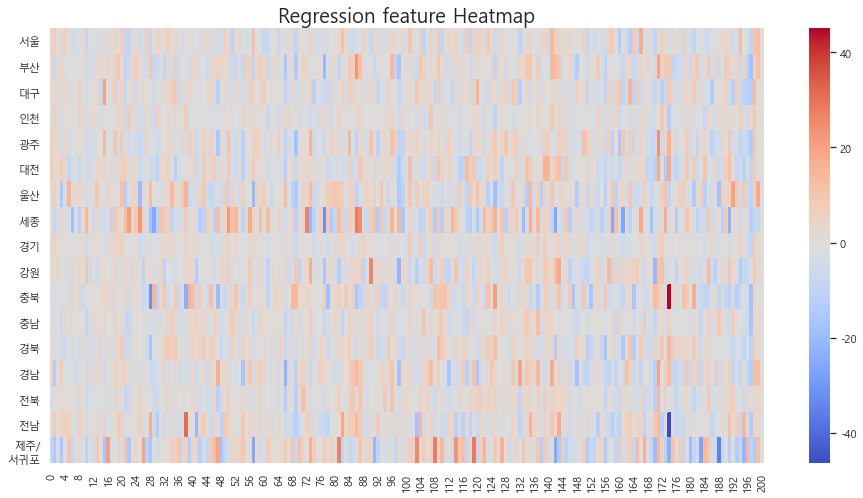

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns

df_regression_feature = pd.DataFrame([avg_model_res_dict['200']['outputs'][d]['lm_d']['features'] for d in name_dist], index = name_dist)

plt.figure(figsize = (16,8))

sns.heatmap(df_regression_feature, cmap='coolwarm')
plt.title('Regression feature Heatmap', fontsize=20)
plt.show()

In [221]:
sorted([(e, x) for e, x in enumerate(avg_model_res_dict['200']['outputs']['서울']['lm_d']['features'])], key = lambda x : - abs(x[1]))[:11]

[(166, 17.70404710803181),
 (141, 13.9225724566836),
 (160, -13.75069811061255),
 (194, 13.70257483218619),
 (163, -12.61703413805036),
 (57, 12.398130757592291),
 (199, 12.251070264401962),
 (82, 11.740360916435801),
 (105, -10.998326342395895),
 (198, 10.386092204307248),
 (101, 10.207882324021377)]

### - RFE

In [142]:
#https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f
from sklearn.feature_selection import RFE
s = RFE(xgboost_dict_d['서울'], n_features_to_select = 10)
s = s.fit(df_xtrain, y_d_train)

In [143]:
s.ranking_[:10]

array([ 69, 106,  78,  71, 103,  79,  72,  52,  70, 150])

### - SelectFromModel

In [146]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(lrm_dict['서울'], threshold=-np.inf, max_features = 10)
sfm = sfm.fit(df_xtrain, y_wr_train)

In [147]:
sfm_idx = sfm.get_support()
sfm_features = df_xtrain.columns[sfm_idx]
sfm_features

Int64Index([9, 16, 17, 71, 74, 75, 91, 149, 153, 175], dtype='int64')

In [148]:
sfm_features.values

array([  9,  16,  17,  71,  74,  75,  91, 149, 153, 175], dtype=int64)

In [155]:
for t in sfm_features.values :
    print("topic {}".format(t))
    print(group_kmeans_keywords[t])
    print()

topic 9
[('감면', 0.9798308813730661), ('취득세', 0.9769067435934945), ('취득세율', 0.9755603913147465), ('영구', 0.9719764343172171), ('소급', 0.9700752859275467), ('종료', 0.9620858116046909), ('지방세', 0.95709175939125), ('한시', 0.9544575964569184), ('한시적', 0.9525360741714153), ('법안', 0.9483091414956687), ('인하', 0.9353295934548395), ('혜택', 0.9256229546763114), ('국회', 0.9177491608037389), ('양도', 0.9138781501090169), ('연장', 0.9128290095082536), ('거래절벽', 0.9074309025547991), ('면제', 0.9062970679265401), ('조치', 0.8986115250234672), ('통과', 0.8964895148938655), ('처리', 0.8934570694301919), ('활성', 0.8930589376948134), ('양도세', 0.8922621563047838), ('세제', 0.8864379018558786), ('취득', 0.8759543544207864), ('연말', 0.8645566137002084), ('생애', 0.8636177305402064), ('폐지', 0.8558063414799455), ('잔금', 0.8542089634747113), ('소득세', 0.8502225227064983), ('활성화', 0.8477293710875689)]

topic 16
[('이스턴타워', 1.0), ('원일종합건설', 0.9996727777176312), ('풍산건설', 0.9991706216602474), ('경기대학교', 0.9991273287216671), ('아주대병원', 0.99907333028

## 2) 9월 데이터로 주요뉴스 & Keywords 추출 (서울)

In [156]:
topictest_news_idx = [e for e, x in enumerate(newstest_ts) if x[0] >= '20210901' and x[0] <= '20210930']

In [157]:
df_test.reset_index(drop=True, inplace = True)
topictest_news_idx = df_test.index[(df_test['published_at'] >= '2021-09-01') & (df_test['published_at'] <= '2021-09-30')]
df_topictest = df_test.iloc[topictest_news_idx]

In [158]:
topic_newstest_ts = []

for row in df_topictest.itertuples() :
    tpvec = tpvec_test[row.Index]
    topic = sorted([(e,tp) for e, tp in enumerate(tpvec)], key = lambda x : -x[1])[0][0]
    topic_newstest_ts.append((row.published_at, topic, row.title, row.keyword.split(',')))

In [159]:
#filter news by topic
topic_newstest_ts = [x for x in topic_newstest_ts if x[1] in sfm_features.values]
print(len(topic_newstest_ts))

22


### - 주요 뉴스 title 30개

In [160]:
import sys
sys.path.insert(0, "C:/Users/medici/Desktop/textrank")
from textrank import KeywordSummarizer
from textrank import KeysentenceSummarizer

def pass_tokenizer(tokens) :
    return tokens

summarizer = KeysentenceSummarizer(
    tokenize = pass_tokenizer,
    min_sim = 0.3,
    verbose = True
)
keysents = summarizer.summarize([item[3] for item in topic_newstest_ts])[:30]
for idx, rank, komoran_sent in keysents:
    print('#{} ({:.3}) : {}'.format(idx, rank, topic_newstest_ts[idx][2]), end='\n')

calculating textrank sentence similarity was done with 22 sents
trained TextRank. n sentences = 22
#11 (1.64) : "저렴한 전세 어디 없나요?" 무주택자들의 설움 '반전세 월세' 더 늘듯
#13 (1.5) : [추석 이후 주택시장 전망] "공급 전세물량 동반 감소"...가을 이사철이 불안하다
#14 (1.35) : "바로 옆집인데 10억 비싸네" '뻥튀기 호가' 난리난 이곳
#7 (1.3) : “세 올려 稅내자”...초고가 월세시대
#15 (1.26) : 서울 전세 평당 1억3000만원 역대 최고
#5 (1.16) : 불장 이어가는 인천 부동산, ‘청라한양수자인 레이크블루’ 호가 얼마?
#1 (1.15) : ‘구해줘! 홈즈’ 나왔던 ‘9억원’ 광진구 아파트의 1년 후 근황[이슈픽]
#10 (1.13) : 지난해보다 더 오른 아파트값, 추석 후엔 잡힐까
#4 (1.09) : <포럼>부동산 재앙 재확인한 국책硏 보고서
#8 (1.04) : 세금發 '아파트 거래절벽'
#3 (0.93) : "30평대 아파트 10억 돌파 속출" '공급 감소' 대전 집값 상승률 광역시 1위
#2 (0.902) : 올해 외지인 아파트 매입 비중 28.1% 2006년 이래 최고
#16 (0.884) : '전세 평당 1억' 잇따라..."전세값 상승률 법시행 직전 1년 3배"
#0 (0.873) : [영상] 공세권 갖춘 이천자이 더 파크, ‘강남 접근성’ 내세웠지만 ‘공원 빼면 글쎄’
#12 (0.842) : DL이앤씨, 집코노미 박람회에 서울 'e편한세상 강일 어반브릿지' 출품
#6 (0.807) : 홍남기 "전 월세 가격 안정 방안, 올해 안에 찾겠다"
#9 (0.797) : 부산에서 가장 비싼 아파트 브랜드는?
#21 (0.751) : 김만배 누나와 거래, 부친 다운계약 의혹 尹, 정면돌파 나섰다
#19 (0.696) : 중국인, 3년 동안 국내 아파트 3조 매수  미국인 2조원 넘어
#20 (0.67)

### - keywords 50개

In [161]:
from textrank import KeywordSummarizer

keyword_extractor = KeywordSummarizer(
    tokenize = pass_tokenizer,
    min_count=5,
    window=-1,                     # cooccurrence within a sentence
    min_cooccurrence=2,
    vocab_to_idx=None,             # you can specify vocabulary to build word graph
    df=0.85,                       # PageRank damping factor
    max_iter=30,                   # PageRank maximum iteration
    verbose=False
)

keywords = keyword_extractor.summarize([item[3] for item in topic_newstest_ts], topk=50)
for word, rank in keywords:
    print(rank, word)

8.122247301488711 아파트
5.695320532866423 월세
4.485731295591362 가격
4.396702766004688 부동산
4.3882041751823 서울
4.223447883951723 전세
3.463378899266944 상승
3.1979539952933753 시장
2.8772365374149835 거래
2.830234382269262 보증금
2.5215274238996646 매물
2.4464351126840587 계약
2.271029519118785 기준
2.2036211131402466 단지
2.0083126204283688 공급
1.9888630289742095 집값
1.8137319828091574 주택
1.748549313998835 시행
1.7071506006876032 매매
1.7060862293928323 1억
1.6977570210912432 임대차
1.6766449708318212 전셋값
1.6225851438276804 지역
1.593923097386298 물량
1.5835444683239843 수도
1.5008219783605394 전용
1.4540545154086533 지난달
1.4175499013167951 정부
1.3482432772510942 수요
1.3182600084272704 상황
1.3079468071851164 금리
1.29237658063282 호가
1.2811294205623618 조사
1.2468718158577605 차이
1.2338815472830493 인상
1.2313725204168717 지속
1.214825187071645 KB
1.1952516329048342 전국
1.1835048075424561 분양
1.1597329757403996 규제
1.15870137972257 수준
1.1459750466555285 교수
1.1194740728764616 반전세
1.112685767622838 부족
1.0918167822837859 평균
1.0903311542989291 7월
